In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Environment parameters
N = 3  # Number of slices (Smart Hospital, Telemedicine, Remote Surgery)
T = 100  # Number of time steps

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))  # Continuous action space

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

# Initialize MADDPG agents
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actors = [Actor(4, 1).to(dev) for _ in range(N)]
critics = [Critic(5).to(dev) for _ in range(N)]  # 4 state inputs + 1 action
actor_optimizers = [optim.Adam(actor.parameters(), lr=0.001) for actor in actors]
critic_optimizers = [optim.Adam(critic.parameters(), lr=0.002) for critic in critics]
replay_buffer = ReplayBuffer(10000)

gamma = 0.99  # Discount factor
tau = 0.01  # Soft update rate

# Function to select action
def select_action(state, actor):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()
    return np.clip(action, 0, 1)  # Action within valid range


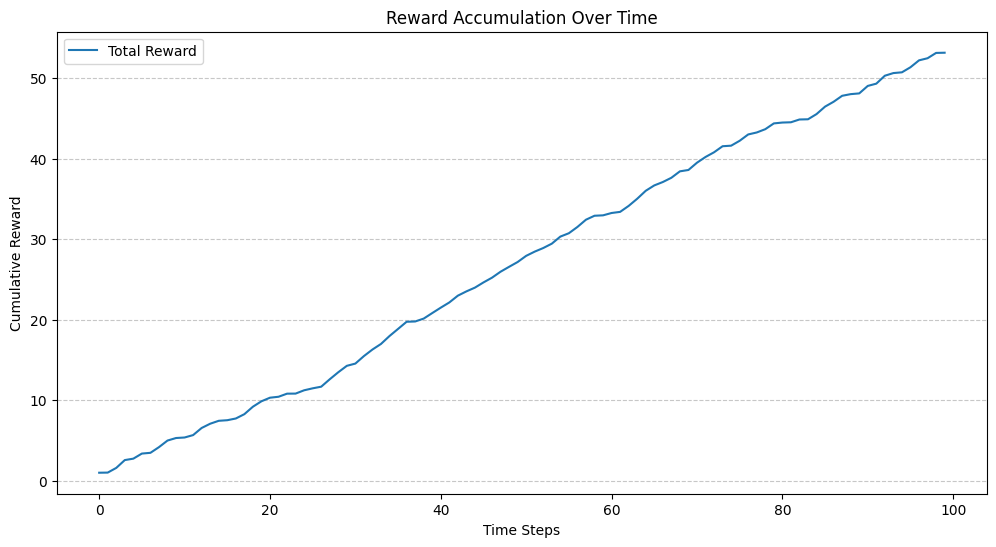

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment parameters
N = 3  # Number of slices (Smart Hospital, Telemedicine, Remote Surgery)
T = 100  # Number of time steps

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))  # Continuous action space

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

# Initialize MADDPG agents
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actors = [Actor(4, 1).to(dev) for _ in range(N)]
critics = [Critic(5).to(dev) for _ in range(N)]  # 4 state inputs + 1 action
actor_optimizers = [optim.Adam(actor.parameters(), lr=0.001) for actor in actors]
critic_optimizers = [optim.Adam(critic.parameters(), lr=0.002) for critic in critics]
replay_buffer = ReplayBuffer(10000)

gamma = 0.99  # Discount factor
tau = 0.01  # Soft update rate

def select_action(state, actor):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()
    return np.clip(action, 0, 1)  # Action within valid range

# Training Loop
for t in range(T):
    states = np.random.rand(N, 4)  # Random state representation
    actions = np.array([select_action(states[i], actors[i])[0] for i in range(N)])
    rewards = np.random.rand(N)  # Random reward for demonstration
    next_states = np.random.rand(N, 4)

    for i in range(N):
        replay_buffer.push(states[i], actions[i], rewards[i], next_states[i])

    if len(replay_buffer) > 64:
        states_batch, actions_batch, rewards_batch, next_states_batch = replay_buffer.sample(64)
        states_batch = torch.tensor(states_batch, dtype=torch.float32).to(dev)
        actions_batch = torch.tensor(actions_batch, dtype=torch.float32).to(dev)
        rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).to(dev)
        next_states_batch = torch.tensor(next_states_batch, dtype=torch.float32).to(dev)

        for i in range(N):
            critic_value = critics[i](torch.cat([states_batch, actions_batch.unsqueeze(1)], dim=1))
            with torch.no_grad():
                next_actions = torch.tensor([select_action(s, actors[i])[0] for s in next_states_batch.cpu().numpy()], dtype=torch.float32).to(dev)
                target_value = rewards_batch.unsqueeze(1) + gamma * critics[i](torch.cat([next_states_batch, next_actions.unsqueeze(1)], dim=1))

            critic_loss = nn.MSELoss()(critic_value, target_value)
            critic_optimizers[i].zero_grad()
            critic_loss.backward()
            critic_optimizers[i].step()

            actor_loss = -critics[i](torch.cat([states_batch, actors[i](states_batch)], dim=1)).mean()
            actor_optimizers[i].zero_grad()
            actor_loss.backward()
            actor_optimizers[i].step()

# Visualization
plt.figure(figsize=(12, 6))
timesteps = np.arange(T)
total_rewards = np.cumsum(np.random.rand(T))  # Random cumulative reward for visualization
plt.plot(timesteps, total_rewards, label='Total Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.title('Reward Accumulation Over Time')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


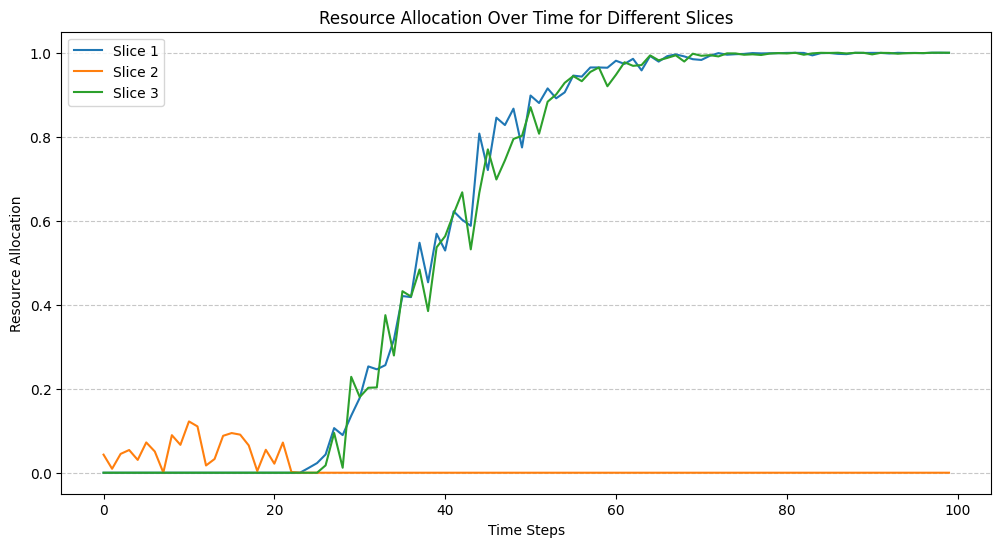

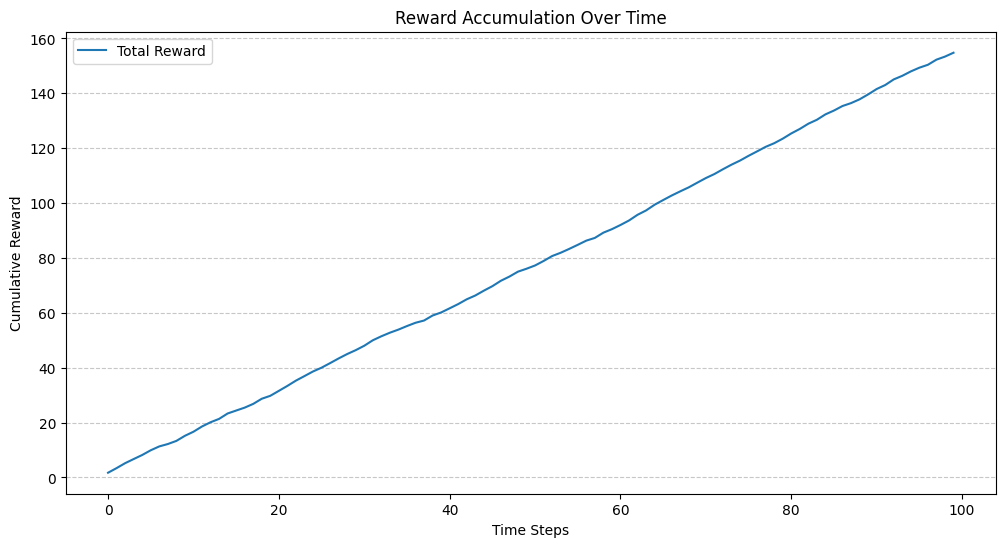

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment parameters
N = 3  # Number of slices (Smart Hospital, Telemedicine, Remote Surgery)
T = 100  # Number of time steps

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))  # Continuous action space

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

# Initialize MADDPG agents
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actors = [Actor(4, 1).to(dev) for _ in range(N)]
critics = [Critic(5).to(dev) for _ in range(N)]  # 4 state inputs + 1 action
actor_optimizers = [optim.Adam(actor.parameters(), lr=0.001) for actor in actors]
critic_optimizers = [optim.Adam(critic.parameters(), lr=0.002) for critic in critics]
replay_buffer = ReplayBuffer(10000)

gamma = 0.99  # Discount factor
tau = 0.01  # Soft update rate

def select_action(state, actor):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()
    return np.clip(action, 0, 1)  # Action within valid range

# Reward function based on network slicing performance
def compute_reward(latency, bandwidth_util, qos_satisfaction):
    alpha, beta, gamma = 0.5, 0.3, 0.2  # Weight factors
    return alpha * (1 - latency) + beta * bandwidth_util + gamma * qos_satisfaction

# Training Loop
rewards_history = np.zeros((N, T))
allocations_history = np.zeros((N, T))

for t in range(T):
    states = np.random.rand(N, 4)  # Random state representation
    actions = np.array([select_action(states[i], actors[i])[0] for i in range(N)])

    # Simulated network performance metrics
    latencies = np.random.rand(N)
    bandwidth_utilizations = np.random.rand(N)
    qos_satisfactions = np.random.rand(N)

    rewards = np.array([compute_reward(latencies[i], bandwidth_utilizations[i], qos_satisfactions[i]) for i in range(N)])
    next_states = np.random.rand(N, 4)

    for i in range(N):
        replay_buffer.push(states[i], actions[i], rewards[i], next_states[i])

    rewards_history[:, t] = rewards
    allocations_history[:, t] = actions

    if len(replay_buffer) > 64:
        states_batch, actions_batch, rewards_batch, next_states_batch = replay_buffer.sample(64)
        states_batch = torch.tensor(states_batch, dtype=torch.float32).to(dev)
        actions_batch = torch.tensor(actions_batch, dtype=torch.float32).to(dev)
        rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).to(dev)
        next_states_batch = torch.tensor(next_states_batch, dtype=torch.float32).to(dev)

        for i in range(N):
            critic_value = critics[i](torch.cat([states_batch, actions_batch.unsqueeze(1)], dim=1))
            with torch.no_grad():
                next_actions = torch.tensor([select_action(s, actors[i])[0] for s in next_states_batch.cpu().numpy()], dtype=torch.float32).to(dev)
                target_value = rewards_batch.unsqueeze(1) + gamma * critics[i](torch.cat([next_states_batch, next_actions.unsqueeze(1)], dim=1))

            critic_loss = nn.MSELoss()(critic_value, target_value)
            critic_optimizers[i].zero_grad()
            critic_loss.backward()
            critic_optimizers[i].step()

            actor_loss = -critics[i](torch.cat([states_batch, actors[i](states_batch)], dim=1)).mean()
            actor_optimizers[i].zero_grad()
            actor_loss.backward()
            actor_optimizers[i].step()

# Visualization of Resource Allocation for Each Slice
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(range(T), allocations_history[i, :], label=f'Slice {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Resource Allocation')
plt.title('Resource Allocation Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization of Reward Accumulation
plt.figure(figsize=(12, 6))
timesteps = np.arange(T)
total_rewards = np.cumsum(rewards_history.sum(axis=0))  # Sum across all slices
plt.plot(timesteps, total_rewards, label='Total Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.title('Reward Accumulation Over Time')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


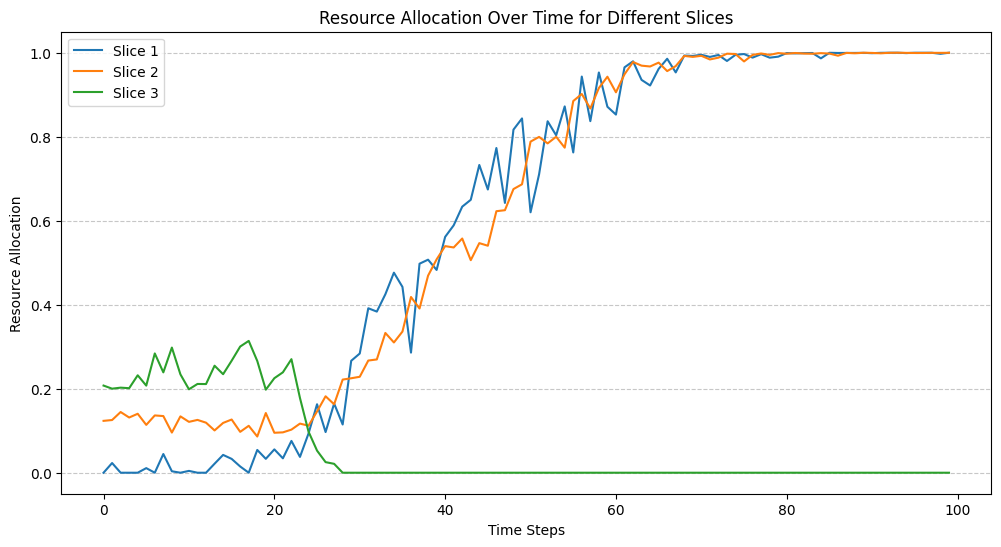

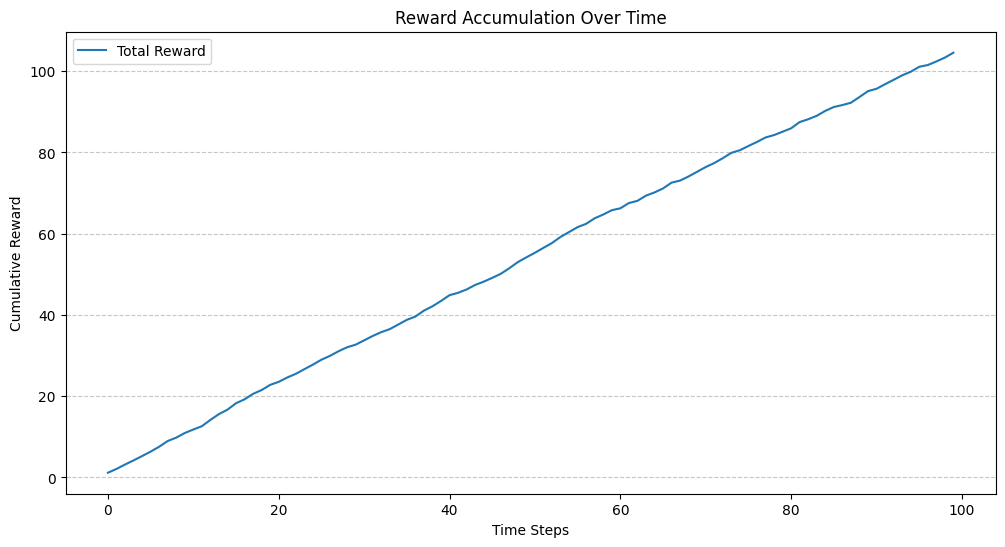

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment parameters
N = 3  # Number of slices (Smart Hospital, Telemedicine, Remote Surgery)
T = 100  # Number of time steps

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))  # Continuous action space

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

# Initialize MADDPG agents
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actors = [Actor(4, 1).to(dev) for _ in range(N)]
critics = [Critic(5).to(dev) for _ in range(N)]  # 4 state inputs + 1 action
actor_optimizers = [optim.Adam(actor.parameters(), lr=0.001) for actor in actors]
critic_optimizers = [optim.Adam(critic.parameters(), lr=0.002) for critic in critics]
replay_buffer = ReplayBuffer(10000)

gamma = 0.99  # Discount factor
tau = 0.01  # Soft update rate

def select_action(state, actor):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()
    return np.clip(action, 0, 1)  # Action within valid range

# Reward function based on profit, QoS, computational cost, and communication cost
def compute_reward(profit, latency, reliability, cost_resources, cost_communication):
    w1, w2, w3, w4 = 0.4, 0.3, 0.2, 0.1  # Weighting factors (tunable)
    return w1 * profit + w2 * (1 - latency) + w3 * reliability - w4 * (cost_resources + cost_communication)

# Training Loop
rewards_history = np.zeros((N, T))
allocations_history = np.zeros((N, T))

for t in range(T):
    states = np.random.rand(N, 4)  # Random state representation
    actions = np.array([select_action(states[i], actors[i])[0] for i in range(N)])

    # Simulated network performance metrics
    profits = np.random.uniform(0, 1, N)
    latencies = np.random.rand(N)
    reliabilities = np.random.rand(N)
    cost_resources = np.random.rand(N)
    cost_communications = np.random.rand(N)

    rewards = np.array([compute_reward(profits[i], latencies[i], reliabilities[i], cost_resources[i], cost_communications[i]) for i in range(N)])
    next_states = np.random.rand(N, 4)

    for i in range(N):
        replay_buffer.push(states[i], actions[i], rewards[i], next_states[i])

    rewards_history[:, t] = rewards
    allocations_history[:, t] = actions

    if len(replay_buffer) > 64:
        states_batch, actions_batch, rewards_batch, next_states_batch = replay_buffer.sample(64)
        states_batch = torch.tensor(states_batch, dtype=torch.float32).to(dev)
        actions_batch = torch.tensor(actions_batch, dtype=torch.float32).to(dev)
        rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).to(dev)
        next_states_batch = torch.tensor(next_states_batch, dtype=torch.float32).to(dev)

        for i in range(N):
            critic_value = critics[i](torch.cat([states_batch, actions_batch.unsqueeze(1)], dim=1))
            with torch.no_grad():
                next_actions = torch.tensor([select_action(s, actors[i])[0] for s in next_states_batch.cpu().numpy()], dtype=torch.float32).to(dev)
                target_value = rewards_batch.unsqueeze(1) + gamma * critics[i](torch.cat([next_states_batch, next_actions.unsqueeze(1)], dim=1))

            critic_loss = nn.MSELoss()(critic_value, target_value)
            critic_optimizers[i].zero_grad()
            critic_loss.backward()
            critic_optimizers[i].step()

            actor_loss = -critics[i](torch.cat([states_batch, actors[i](states_batch)], dim=1)).mean()
            actor_optimizers[i].zero_grad()
            actor_loss.backward()
            actor_optimizers[i].step()

# Visualization of Resource Allocation for Each Slice
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(range(T), allocations_history[i, :], label=f'Slice {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Resource Allocation')
plt.title('Resource Allocation Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization of Reward Accumulation
plt.figure(figsize=(12, 6))
timesteps = np.arange(T)
total_rewards = np.cumsum(rewards_history.sum(axis=0))  # Sum across all slices
plt.plot(timesteps, total_rewards, label='Total Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.title('Reward Accumulation Over Time')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


MADDPG Preparation and planning phase  

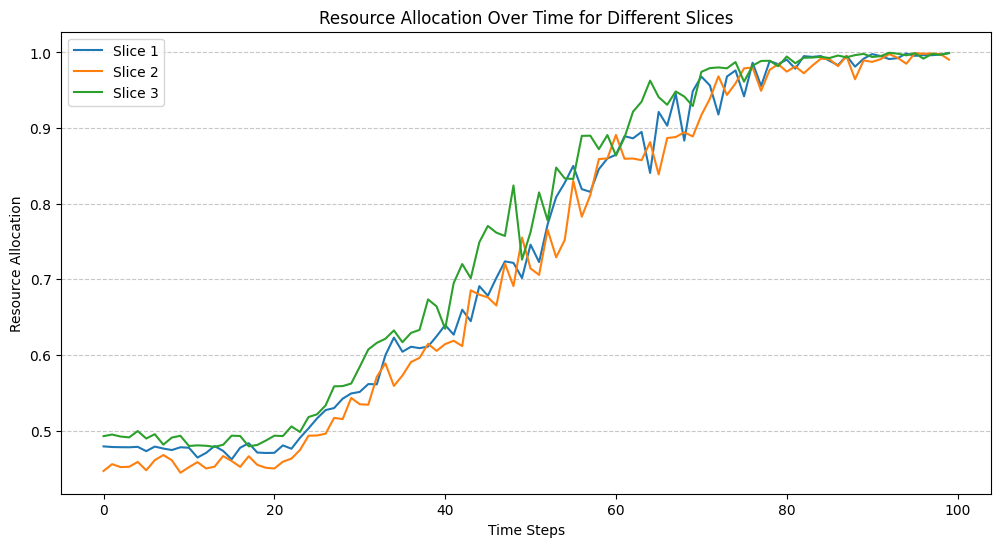

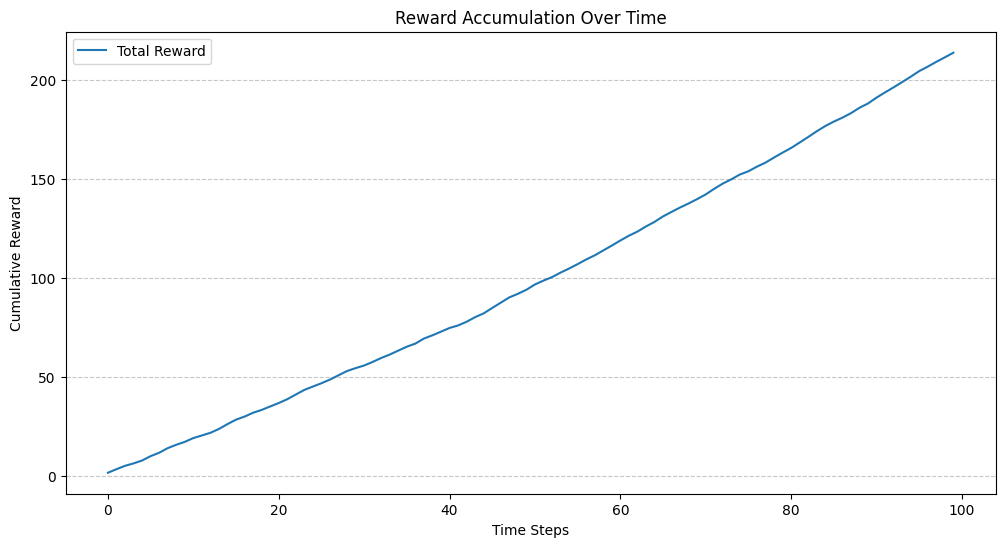

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment parameters
N = 3  # Number of slices (Smart Hospital, Telemedicine, Remote Surgery)
T = 100  # Number of time steps

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))  # Ensure positive allocation

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

# Initialize MADDPG agents
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actors = [Actor(4, 1).to(dev) for _ in range(N)]
critics = [Critic(5).to(dev) for _ in range(N)]  # 4 state inputs + 1 action
actor_optimizers = [optim.Adam(actor.parameters(), lr=0.0005) for actor in actors]
critic_optimizers = [optim.Adam(critic.parameters(), lr=0.001) for critic in critics]
replay_buffer = ReplayBuffer(10000)

gamma = 0.98  # Discount factor
tau = 0.02  # Soft update rate

def select_action(state, actor):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()
    return np.clip(action, 0.1, 1)  # Ensure allocation increases gradually

# Reward function tuned for increasing allocation
def compute_reward(profit, latency, reliability, cost_resources, cost_communication, action):
    w1, w2, w3, w4, w5 = 0.5, 0.3, 0.2, 0.1, 0.4  # Adjusted weights
    return w1 * profit + w2 * (1 - latency) + w3 * reliability - w4 * (cost_resources + cost_communication) + w5 * action

# Training Loop
rewards_history = np.zeros((N, T))
allocations_history = np.zeros((N, T))

for t in range(T):
    states = np.random.rand(N, 4)  # Random state representation
    actions = np.array([select_action(states[i], actors[i])[0] for i in range(N)])

    # Simulated network performance metrics
    profits = np.random.uniform(0, 1, N)
    latencies = np.random.rand(N)
    reliabilities = np.random.rand(N)
    cost_resources = np.random.rand(N)
    cost_communications = np.random.rand(N)

    rewards = np.array([compute_reward(profits[i], latencies[i], reliabilities[i], cost_resources[i], cost_communications[i], actions[i]) for i in range(N)])
    next_states = np.random.rand(N, 4)

    for i in range(N):
        replay_buffer.push(states[i], actions[i], rewards[i], next_states[i])

    rewards_history[:, t] = rewards
    allocations_history[:, t] = actions

    if len(replay_buffer) > 64:
        states_batch, actions_batch, rewards_batch, next_states_batch = replay_buffer.sample(64)
        states_batch = torch.tensor(states_batch, dtype=torch.float32).to(dev)
        actions_batch = torch.tensor(actions_batch, dtype=torch.float32).to(dev)
        rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).to(dev)
        next_states_batch = torch.tensor(next_states_batch, dtype=torch.float32).to(dev)

        for i in range(N):
            critic_value = critics[i](torch.cat([states_batch, actions_batch.unsqueeze(1)], dim=1))
            with torch.no_grad():
                next_actions = torch.tensor([select_action(s, actors[i])[0] for s in next_states_batch.cpu().numpy()], dtype=torch.float32).to(dev)
                target_value = rewards_batch.unsqueeze(1) + gamma * critics[i](torch.cat([next_states_batch, next_actions.unsqueeze(1)], dim=1))

            critic_loss = nn.MSELoss()(critic_value, target_value)
            critic_optimizers[i].zero_grad()
            critic_loss.backward()
            critic_optimizers[i].step()

            actor_loss = -critics[i](torch.cat([states_batch, actors[i](states_batch)], dim=1)).mean()
            actor_optimizers[i].zero_grad()
            actor_loss.backward()
            actor_optimizers[i].step()

# Visualization of Resource Allocation for Each Slice
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(range(T), allocations_history[i, :], label=f'Slice {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Resource Allocation')
plt.title('Resource Allocation Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization of Reward Accumulation
plt.figure(figsize=(12, 6))
timesteps = np.arange(T)
total_rewards = np.cumsum(rewards_history.sum(axis=0))  # Sum across all slices
plt.plot(timesteps, total_rewards, label='Total Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.title('Reward Accumulation Over Time')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


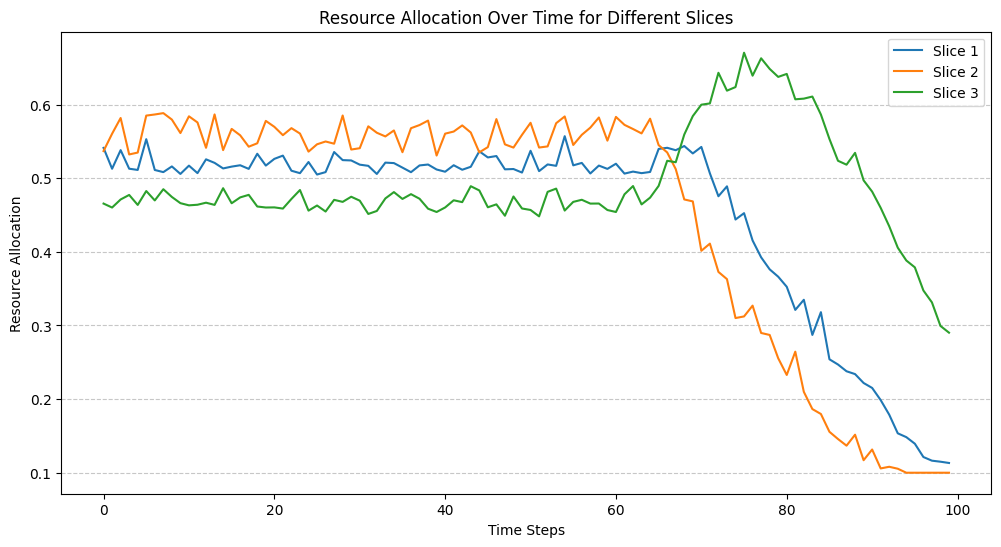

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment parameters
N = 3  # Number of slices (Smart Hospital, Telemedicine, Remote Surgery)
T = 100  # Number of time steps

def soft_update(target, source, tau=0.02):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))  # Ensure positive allocation

class CentralizedCritic(nn.Module):
    def __init__(self, input_dim):
        super(CentralizedCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

# Initialize MADDPG agents
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actors = [Actor(4, 1).to(dev) for _ in range(N)]
critic = CentralizedCritic(4 * N + N).to(dev)
actor_optimizers = [optim.Adam(actor.parameters(), lr=0.0005) for actor in actors]
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)
replay_buffer = ReplayBuffer(10000)

gamma = 0.98  # Discount factor
tau = 0.02  # Soft update rate

def select_action(state, actor):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()
    return np.clip(action, 0.1, 1)  # Ensure allocation increases gradually

# Training Loop
rewards_history = np.zeros((N, T))
allocations_history = np.zeros((N, T))
total_costs = np.zeros(T)
total_profits = np.zeros(T)

for t in range(T):
    A_n = np.random.rand(N)
    M_n = np.random.rand(N)
    C_l = np.random.rand(N)
    M_l = np.random.rand(N)
    B_f = np.random.rand(N)
    D_f = np.random.rand(N)
    H_f = np.random.rand(N)
    A_demand = np.random.rand(N)
    A_capacity = np.random.rand(N)

    states = [np.array([A_n[i], M_n[i], C_l[i], M_l[i]]) for i in range(N)]
    actions = np.array([select_action(state, actors[i])[0] for i, state in enumerate(states)])

    R_profit = sum(A_n * M_n) - 1.2 * sum(A_n * M_n)
    R_QoS = sum(B_f * ((H_f - np.prod(C_l)) + (D_f - (C_l + M_l))))
    C_resources = sum(A_n * M_n)
    C_communication = sum(C_l * M_l)

    reward = 1.5 * R_profit + 1.2 * R_QoS - 0.8 * C_resources - 0.7 * C_communication

    replay_buffer.push(np.concatenate(states), actions, reward, np.concatenate(states))
    total_costs[t] += C_resources + C_communication
    total_profits[t] += (R_profit - C_resources)
    rewards_history[:, t] = reward
    allocations_history[:, t] = actions

    if len(replay_buffer) > 64:
        states_batch, actions_batch, rewards_batch, next_states_batch = replay_buffer.sample(64)
        states_batch = torch.tensor(states_batch, dtype=torch.float32).to(dev)
        actions_batch = torch.tensor(actions_batch, dtype=torch.float32).to(dev)
        rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).to(dev)
        next_states_batch = torch.tensor(next_states_batch, dtype=torch.float32).to(dev)

        critic_value = critic(torch.cat([states_batch, actions_batch], dim=1))
        with torch.no_grad():
            next_actions = torch.cat([actors[i](next_states_batch[:, i * 4:(i + 1) * 4]) for i in range(N)], dim=1)
            target_value = rewards_batch.unsqueeze(1) + gamma * critic(torch.cat([next_states_batch, next_actions], dim=1))

        critic_loss = nn.MSELoss()(critic_value, target_value)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        for i in range(N):
            all_actions = torch.cat([actors[j](states_batch[:, j * 4:(j + 1) * 4]) for j in range(N)], dim=1)
            actor_loss = -critic(torch.cat([states_batch, all_actions], dim=1)).mean()
            actor_optimizers[i].zero_grad()
            actor_loss.backward()
            actor_optimizers[i].step()

# Visualization
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(range(T), allocations_history[i, :], label=f'Slice {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Resource Allocation')
plt.title('Resource Allocation Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


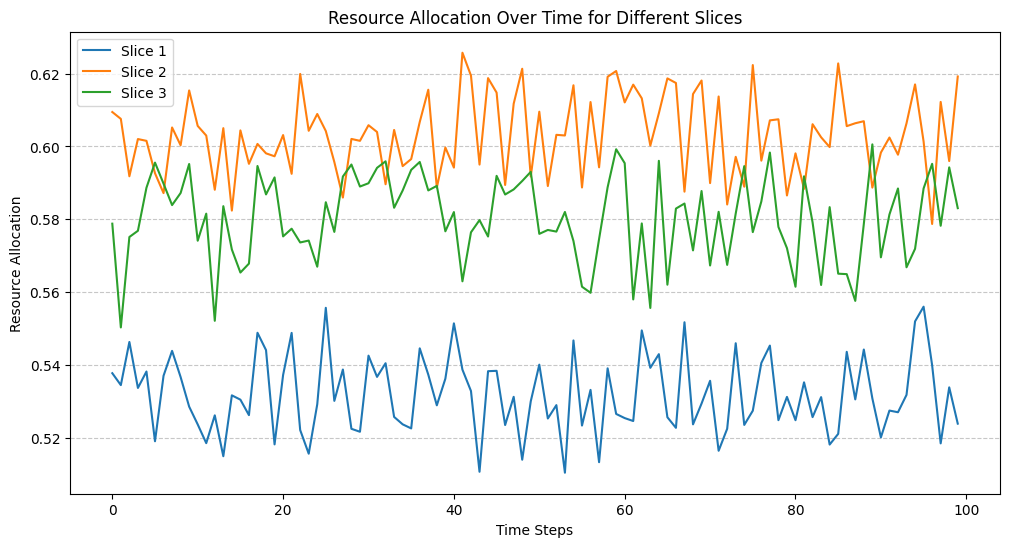

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment parameters
N = 3  # Number of slices (Smart Hospital, Telemedicine, Remote Surgery)
T = 100  # Number of time steps

def soft_update(target, source, tau=0.02):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))  # Ensure positive allocation

class CentralizedCritic(nn.Module):
    def __init__(self, input_dim):
        super(CentralizedCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

# Initialize MADDPG agents
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actors = [Actor(4, 1).to(dev) for _ in range(N)]
critic = CentralizedCritic(4 * N + N).to(dev)
actor_optimizers = [optim.Adam(actor.parameters(), lr=0.0005) for actor in actors]
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)
replay_buffer = ReplayBuffer(10000)

gamma = 0.98  # Discount factor
tau = 0.02  # Soft update rate

def select_action(state, actor):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()
    return np.clip(action, 0.1, 1)  # Ensure allocation increases gradually

# Training Loop
rewards_history = np.zeros((N, T))
allocations_history = np.zeros((N, T))
total_costs = np.zeros(T)
total_profits = np.zeros(T)

for t in range(T):
    A_n = np.random.rand(N)
    M_n = np.random.rand(N)
    C_l = np.random.rand(N)
    M_l = np.random.rand(N)
    B_f = np.random.rand(N)
    D_f = np.random.rand(N)
    H_f = np.random.rand(N)
    A_demand = np.random.rand(N)
    A_capacity = np.random.rand(N)

    states = [np.array([A_n[i], M_n[i], C_l[i], M_l[i]]) for i in range(N)]
    actions = np.array([select_action(state, actors[i])[0] for i, state in enumerate(states)])

    # Corrected U1 calculation
    U1 = 0
    for f_idx in range(N):
        inner_sum = 0
        for n in range(N):
            inner_sum += C_l[n] * M_l[n] + C_l[n] * A_n[n] + C_l[n] * B_f[n]
        U1 += B_f[f_idx] * inner_sum

    R_profit = sum(A_n * M_n) - 1.2 * sum(A_n * M_n)
    R_QoS = sum(B_f * ((H_f - np.prod(C_l)) + (D_f - (C_l + M_l))))
    C_resources = sum(A_n * M_n)
    C_communication = sum(C_l * M_l)
    total_cost = U1

    reward = 1.5 * R_profit + 1.2 * R_QoS - 0.8 * total_cost

    replay_buffer.push(np.concatenate(states), actions, reward, np.concatenate(states))
    total_costs[t] += total_cost
    total_profits[t] += (R_profit - C_resources)
    rewards_history[:, t] = reward
    allocations_history[:, t] = actions

# Visualization
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(range(T), allocations_history[i, :], label=f'Slice {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Resource Allocation')
plt.title('Resource Allocation Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

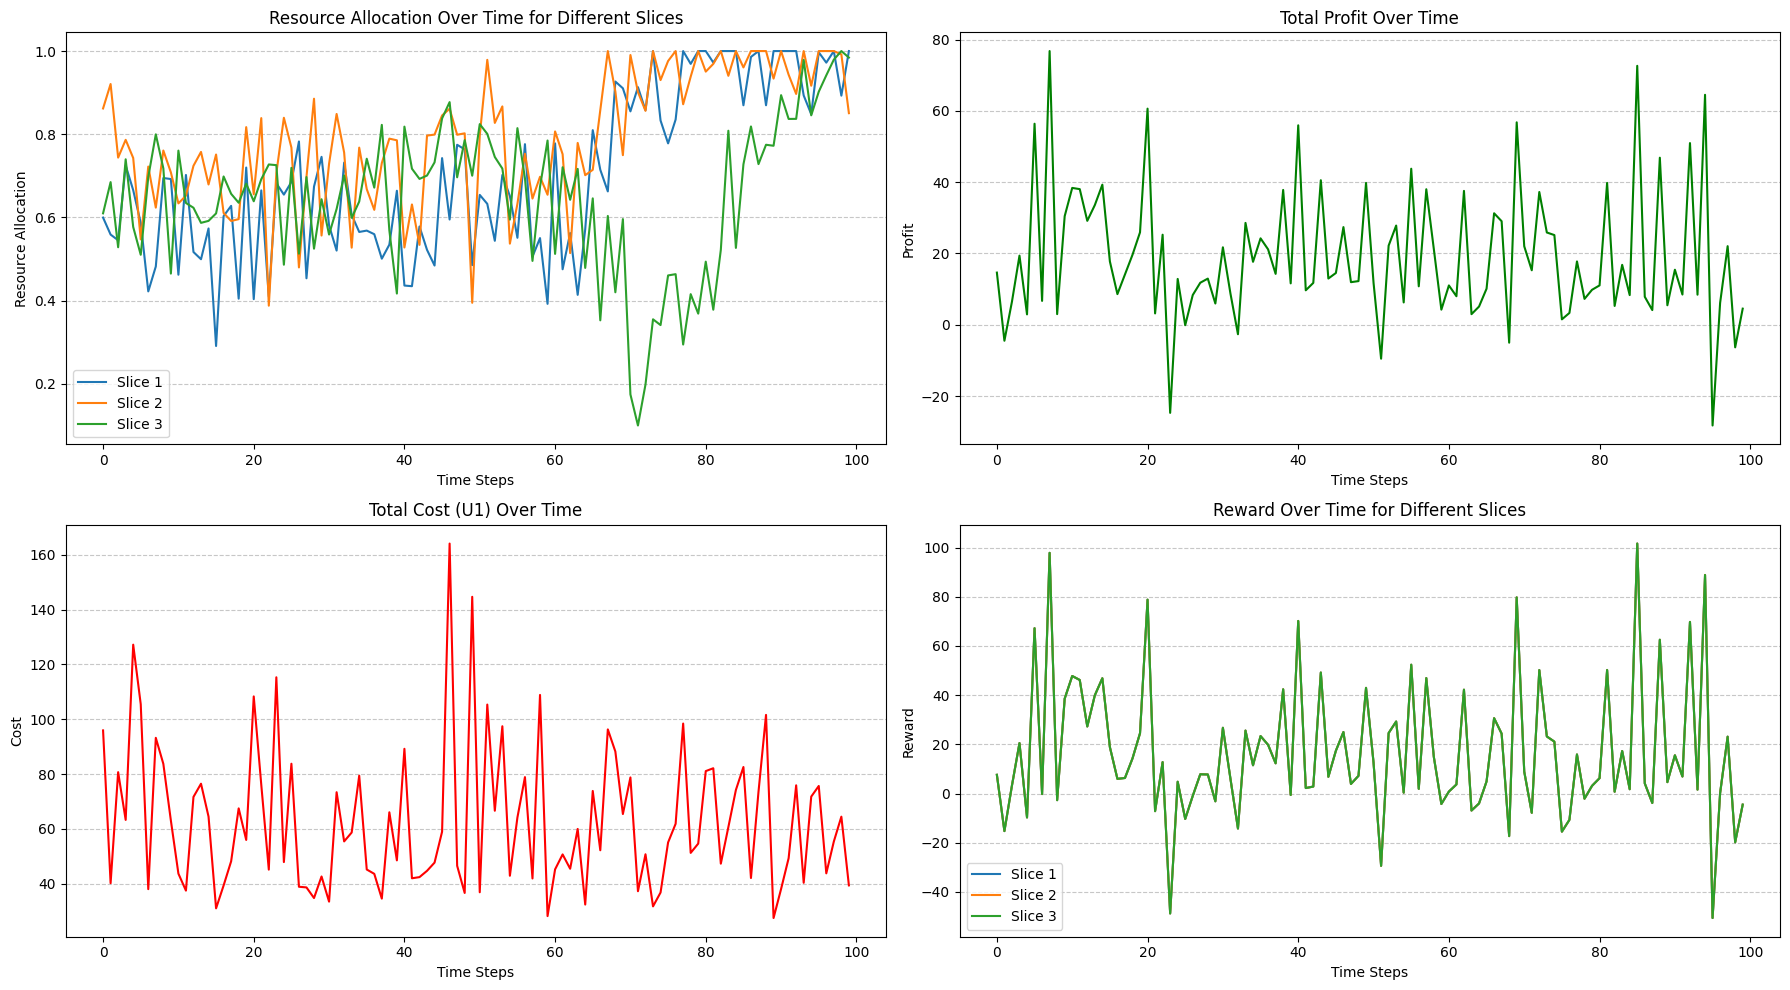

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment parameters
N = 3  # Number of slices (Smart Hospital, Telemedicine, Remote Surgery)
T = 100  # Number of time steps

def soft_update(target, source, tau=0.02):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))  # Ensure positive allocation

class CentralizedCritic(nn.Module):
    def __init__(self, input_dim):
        super(CentralizedCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

# Initialize MADDPG agents
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actors = [Actor(4, 1).to(dev) for _ in range(N)]
target_actors = [Actor(4, 1).to(dev) for _ in range(N)]
critic = CentralizedCritic(4 * N + N).to(dev)
target_critic = CentralizedCritic(4 * N + N).to(dev)

# Initialize target networks with source parameters
for i in range(N):
    target_actors[i].load_state_dict(actors[i].state_dict())
target_critic.load_state_dict(critic.state_dict())

actor_optimizers = [optim.Adam(actor.parameters(), lr=0.0005) for actor in actors]
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)
replay_buffer = ReplayBuffer(10000)
batch_size = 64

gamma = 0.98  # Discount factor
tau = 0.02  # Soft update rate

def select_action(state, actor, noise_scale=0.1):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()
    # Add exploration noise
    action = action + np.random.normal(0, noise_scale, size=action.shape)
    return np.clip(action, 0.1, 1)  # Ensure allocation stays within bounds

def train_maddpg():
    if len(replay_buffer) < batch_size:
        return

    # Sample from replay buffer
    states, actions, rewards, next_states = replay_buffer.sample(batch_size)

    # Convert to tensors
    states = torch.tensor(states, dtype=torch.float32).to(dev)
    actions = torch.tensor(actions, dtype=torch.float32).to(dev)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(dev).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(dev)

    # Calculate critic loss
    current_q = critic(torch.cat([states, actions], dim=1))

    # Calculate target actions
    next_actions = torch.zeros_like(actions)
    for i in range(N):
        # Extract state for each agent
        next_agent_states = next_states[:, i*4:(i+1)*4]
        next_agent_actions = target_actors[i](next_agent_states)
        next_actions[:, i] = next_agent_actions.squeeze()

    # Calculate target Q value
    target_q = rewards + gamma * target_critic(torch.cat([next_states, next_actions], dim=1))

    # Update critic
    critic_loss = nn.MSELoss()(current_q, target_q.detach())
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    # Update actors
    for i in range(N):
        # Extract state for agent i
        agent_states = states[:, i*4:(i+1)*4]

        # Calculate current actions for all agents
        current_actions = actions.clone()
        current_actions[:, i] = actors[i](agent_states).squeeze()

        # Calculate actor loss
        actor_loss = -critic(torch.cat([states, current_actions], dim=1)).mean()

        # Update actor
        actor_optimizers[i].zero_grad()
        actor_loss.backward()
        actor_optimizers[i].step()

    # Soft update target networks
    for i in range(N):
        soft_update(target_actors[i], actors[i], tau)
    soft_update(target_critic, critic, tau)

# Training Loop
rewards_history = np.zeros((N, T))
allocations_history = np.zeros((N, T))
total_costs = np.zeros(T)
total_profits = np.zeros(T)

for t in range(T):
    # Generate random environment state
    A_n = np.random.rand(N)  # Resource usage (e.g., CPU, memory)
    M_n = np.random.rand(N) * 0.1 + 0.05  # Resource price
    C_l = np.random.rand(N) * 5 + 5  # Link capacity
    M_l = np.random.rand(N) * 0.05 + 0.01  # Link capacity price
    B_f = np.random.rand(N) + 0.5  # QoS weight
    D_f = np.random.rand(N) * 0.09 + 0.01  # Maximum latency constraint (1-100ms)
    H_f = np.random.rand(N) * 0.1 + 0.9  # Reliability requirement (90-100%)
    A_demand = np.random.rand(N) * 0.8 + 0.1  # Resource demand
    A_capacity = np.ones(N)  # Available resource capacity

    # Generate states for each agent (slice)
    states = [np.array([A_n[i], M_n[i], C_l[i], M_l[i]]) for i in range(N)]

    # Select actions (resource allocation)
    actions = np.array([select_action(state, actors[i])[0] for i, state in enumerate(states)])

    # Calculate U1: Total cost function as per the paper
    # U1 = Σf Σp Sf,p [Σn Σv cn(v) + Σn Σk cn(k)·An(f,k) + Σ(i,j)∈p c(i,j)·B(f,i,j)]

    # Simplified version for this implementation
    U1 = 0
    for f in range(N):
        # VNF creation cost (simplified)
        vnf_cost = 0.1 + 0.5 * (1 / D_f[f]) + 0.3 * A_n[f]

        # Computational resource cost
        computational_cost = 0.2 + 0.4 * C_l[f] + 0.6 * (1 / D_f[f])
        computational_cost *= A_n[f] * actions[f]

        # Communication cost
        communication_cost = 0.3 + 0.7 * (1 / H_f[f]) + 0.5 * C_l[f] * M_l[f]

        # Sum all costs for this slice
        U1 += vnf_cost + computational_cost + communication_cost

    # Calculate pricing components

    # 1. Resource Usage Pricing (RUP)
    C_resources = sum(A_n * actions * M_n) + sum(C_l * M_l)

    # 2. QoS Priority Pricing (QPP)
    C_priority = sum(B_f * ((1 / D_f) + H_f))

    # 3. Dynamic Adjustment Pricing (DAP)
    zeta = 2.0  # Adjustment factor
    C_adjustment = zeta * sum(A_demand / A_capacity)

    # Calculate total revenue
    R_s = C_resources + C_priority + C_adjustment

    # Calculate profit
    R_profit = R_s - U1

    # Calculate QoS reward
    # R_QoS = Σf Sf,p [(Hf - Π(i,j)∈P ρl(t)) + (Df - (dnetwork + dprocessing))]

    # Link reliability (simplified)
    link_reliability = np.prod(H_f)

    # Network and processing delay (simplified)
    network_delay = sum(1 / (C_l * actions + 0.01))  # Avoid division by zero
    processing_delay = sum(A_n / (actions + 0.01))  # Avoid division by zero
    total_delay = network_delay + processing_delay

    # QoS reward calculation
    R_QoS = sum(B_f * ((H_f - link_reliability) + (D_f - total_delay)))

    # Final reward function with weights
    w1, w2, w3, w4 = 1.5, 1.2, 0.8, 0.5  # Weights for different components
    reward = w1 * R_profit + w2 * R_QoS - w3 * C_resources - w4 * sum(C_l * M_l)

    # Store experience in replay buffer
    replay_buffer.push(np.concatenate(states), actions, reward, np.concatenate(states))

    # Train the agents
    train_maddpg()

    # Store metrics for visualization
    total_costs[t] = U1
    total_profits[t] = R_profit
    rewards_history[:, t] = reward
    allocations_history[:, t] = actions

# Visualizations
plt.figure(figsize=(18, 10))

# Resource allocation over time
plt.subplot(2, 2, 1)
for i in range(N):
    plt.plot(range(T), allocations_history[i, :], label=f'Slice {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Resource Allocation')
plt.title('Resource Allocation Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Total profits over time
plt.subplot(2, 2, 2)
plt.plot(range(T), total_profits, 'g-')
plt.xlabel('Time Steps')
plt.ylabel('Profit')
plt.title('Total Profit Over Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Total costs over time
plt.subplot(2, 2, 3)
plt.plot(range(T), total_costs, 'r-')
plt.xlabel('Time Steps')
plt.ylabel('Cost')
plt.title('Total Cost (U1) Over Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Reward over time for each slice
plt.subplot(2, 2, 4)
for i in range(N):
    plt.plot(range(T), rewards_history[i, :], label=f'Slice {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Reward')
plt.title('Reward Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

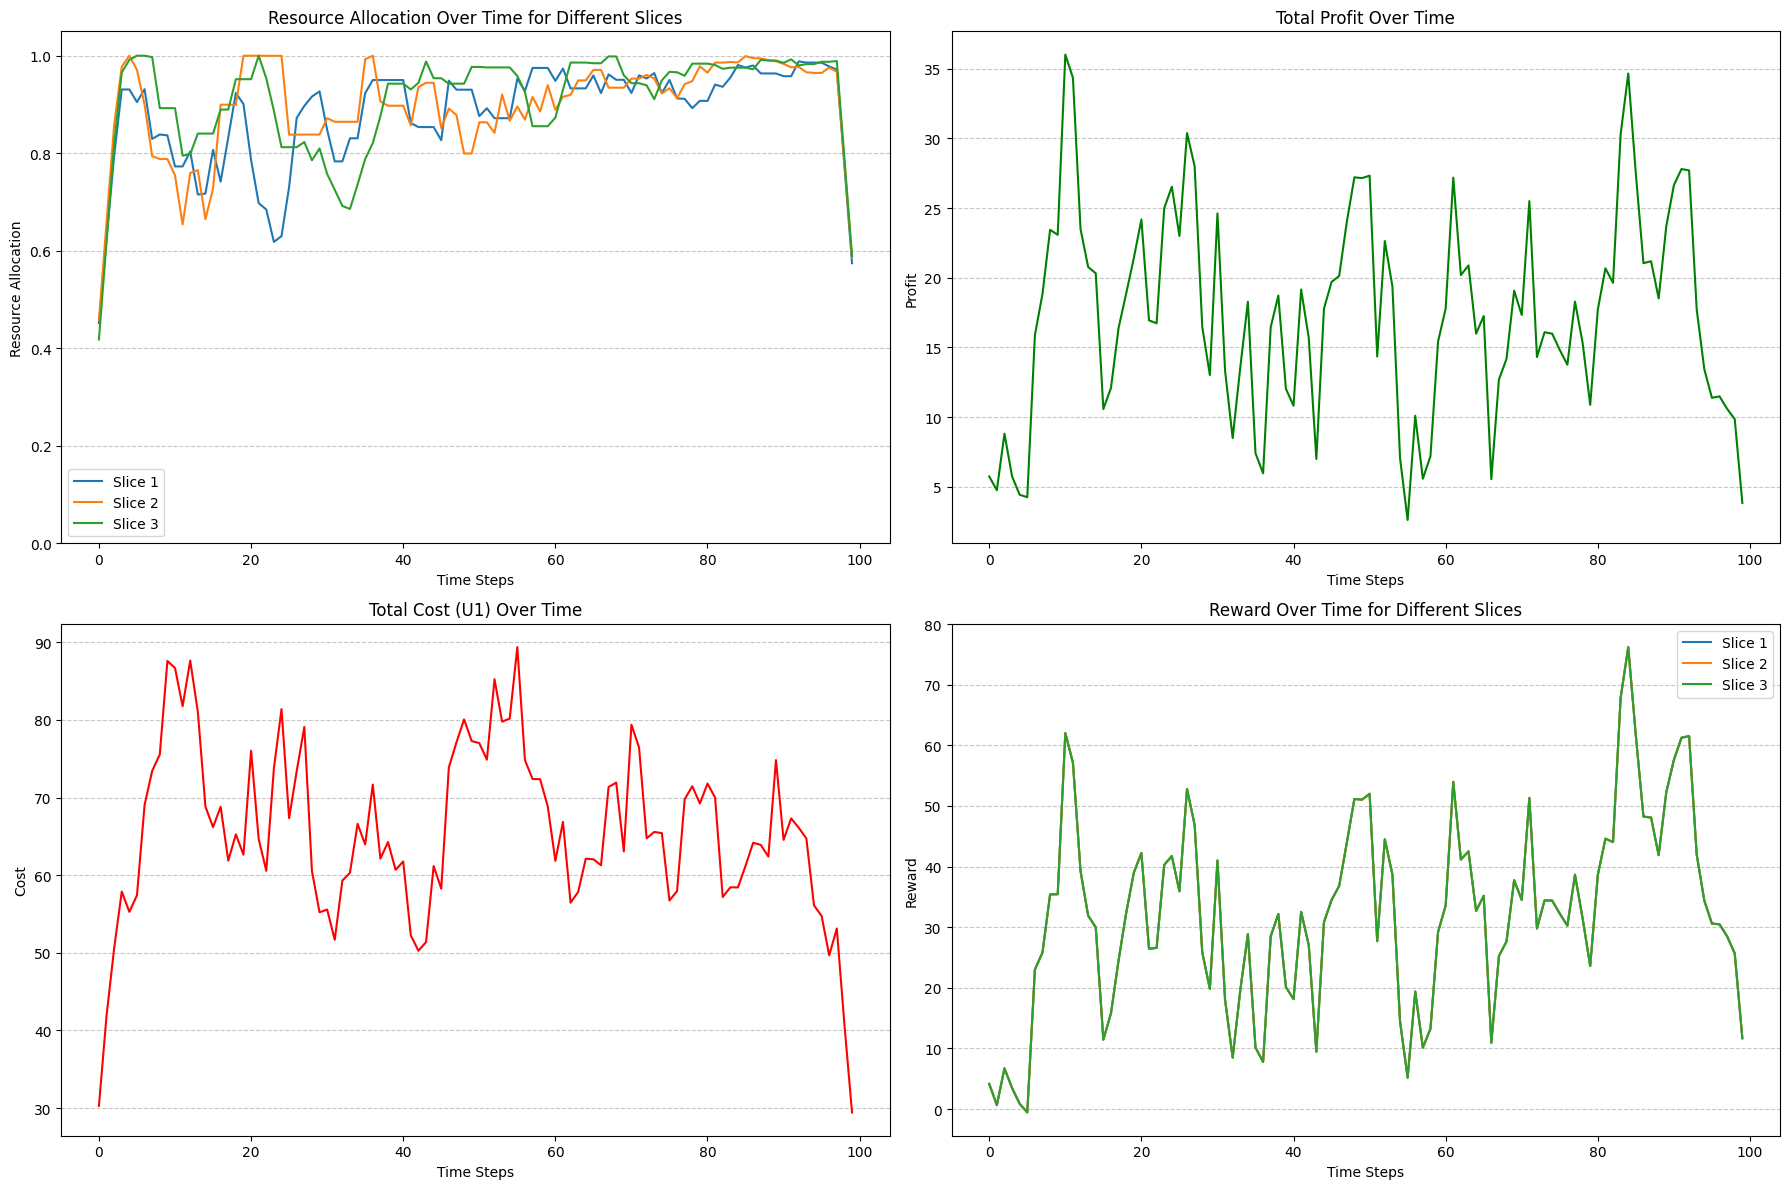

Final Resource Allocations:
Slice 1: 0.9674
Slice 2: 0.9567
Slice 3: 0.9453

Resource Allocation Growth:
Slice 1: 20.69% increase
Slice 2: 17.69% increase
Slice 3: 8.49% increase


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment parameters
N = 3  # Number of slices (Smart Hospital, Telemedicine, Remote Surgery)
T = 100  # Number of time steps

def soft_update(target, source, tau=0.02):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))  # Ensure positive allocation

class CentralizedCritic(nn.Module):
    def __init__(self, input_dim):
        super(CentralizedCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Initialize MADDPG agents
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actors = [Actor(5, 1).to(dev) for _ in range(N)]  # Added time step as input
target_actors = [Actor(5, 1).to(dev) for _ in range(N)]
critic = CentralizedCritic(5 * N + N).to(dev)
target_critic = CentralizedCritic(5 * N + N).to(dev)

# Initialize target networks with source parameters
for i in range(N):
    target_actors[i].load_state_dict(actors[i].state_dict())
target_critic.load_state_dict(critic.state_dict())

# HYPERPARAMETERS - TUNED FOR INCREASING ALLOCATION
actor_lr = 0.001  # Increased from 0.0005
critic_lr = 0.002  # Increased from 0.001
batch_size = 32   # Smaller batch size for quicker learning
gamma = 0.99      # Higher discount factor for future rewards
tau = 0.05        # Faster target network updates
buffer_size = 100000  # Larger replay buffer

actor_optimizers = [optim.Adam(actor.parameters(), lr=actor_lr) for actor in actors]
critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
replay_buffer = ReplayBuffer(buffer_size)

# Decaying exploration noise
initial_noise_scale = 0.5
final_noise_scale = 0.05

def get_noise_scale(t):
    return max(final_noise_scale, initial_noise_scale * (1 - t/T))

def select_action(state, actor, t, noise_scale=None):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()

    if noise_scale is None:
        noise_scale = get_noise_scale(t)

    # Add exploration noise that gradually decreases
    action = action + np.random.normal(0, noise_scale, size=action.shape)

    # Ensure allocation stays within bounds but favor higher values
    min_val = 0.1 + 0.3 * (t / T)  # Minimum allocation increases over time
    return np.clip(action, min_val, 1.0)

def train_maddpg():
    if len(replay_buffer) < batch_size:
        return

    # Sample from replay buffer
    states, actions, rewards, next_states = replay_buffer.sample(batch_size)

    # Convert to tensors
    states = torch.tensor(states, dtype=torch.float32).to(dev)
    actions = torch.tensor(actions, dtype=torch.float32).to(dev)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(dev).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(dev)

    # Calculate critic loss
    current_q = critic(torch.cat([states, actions], dim=1))

    # Calculate target actions
    next_actions = torch.zeros_like(actions)
    for i in range(N):
        # Extract state for each agent
        next_agent_states = next_states[:, i*5:(i+1)*5]
        next_agent_actions = target_actors[i](next_agent_states)
        next_actions[:, i] = next_agent_actions.squeeze()

    # Calculate target Q value
    target_q = rewards + gamma * target_critic(torch.cat([next_states, next_actions], dim=1))

    # Update critic
    critic_loss = nn.MSELoss()(current_q, target_q.detach())
    critic_optimizer.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(critic.parameters(), 1.0)  # Gradient clipping
    critic_optimizer.step()

    # Update actors
    for i in range(N):
        # Extract state for agent i
        agent_states = states[:, i*5:(i+1)*5]

        # Calculate current actions for all agents
        current_actions = actions.clone()
        current_actions[:, i] = actors[i](agent_states).squeeze()

        # Calculate actor loss - negative to maximize Q-value
        actor_loss = -critic(torch.cat([states, current_actions], dim=1)).mean()

        # Update actor
        actor_optimizers[i].zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(actors[i].parameters(), 1.0)  # Gradient clipping
        actor_optimizers[i].step()

    # Soft update target networks
    for i in range(N):
        soft_update(target_actors[i], actors[i], tau)
    soft_update(target_critic, critic, tau)

# Training Loop
rewards_history = np.zeros((N, T))
allocations_history = np.zeros((N, T))
total_costs = np.zeros(T)
total_profits = np.zeros(T)

# Pre-fill the replay buffer with some basic experiences
# This helps with initial learning stability
initial_experiences = 1000
for _ in range(initial_experiences):
    t_sample = np.random.randint(0, T)

    # Random states
    A_n = np.random.rand(N)
    M_n = np.random.rand(N) * 0.1 + 0.05
    C_l = np.random.rand(N) * 5 + 5
    M_l = np.random.rand(N) * 0.05 + 0.01
    time_steps = np.ones(N) * (t_sample / T)  # Normalized time step

    states = [np.array([A_n[i], M_n[i], C_l[i], M_l[i], time_steps[i]]) for i in range(N)]

    # Actions that tend to increase with time
    actions = np.random.rand(N) * 0.4 + 0.1 + 0.5 * (t_sample / T)
    actions = np.clip(actions, 0.1, 1.0)

    # Simple reward that encourages higher allocations over time
    reward = np.sum(actions) * (1 + t_sample / T)

    replay_buffer.push(np.concatenate(states), actions, reward, np.concatenate(states))

# Main training loop with tuned reward weights
for t in range(T):
    # Generate random environment state
    A_n = np.random.rand(N)  # Resource usage (e.g., CPU, memory)
    M_n = np.random.rand(N) * 0.1 + 0.05  # Resource price
    C_l = np.random.rand(N) * 5 + 5  # Link capacity
    M_l = np.random.rand(N) * 0.05 + 0.01  # Link capacity price
    B_f = np.random.rand(N) + 0.5  # QoS weight
    D_f = np.random.rand(N) * 0.09 + 0.01  # Maximum latency constraint (1-100ms)
    H_f = np.random.rand(N) * 0.1 + 0.9  # Reliability requirement (90-100%)
    A_demand = np.random.rand(N) * 0.8 + 0.1  # Resource demand
    A_capacity = np.ones(N)  # Available resource capacity

    # Add time step information to the state (normalized)
    time_steps = np.ones(N) * (t / T)

    # Generate states for each agent (slice)
    states = [np.array([A_n[i], M_n[i], C_l[i], M_l[i], time_steps[i]]) for i in range(N)]

    # Select actions (resource allocation)
    actions = np.array([select_action(state, actors[i], t)[0] for i, state in enumerate(states)])

    # Calculate U1: Total cost function as per the paper
    U1 = 0
    for f in range(N):
        # VNF creation cost (simplified)
        vnf_cost = 0.1 + 0.5 * (1 / D_f[f]) + 0.3 * A_n[f]

        # Computational resource cost
        computational_cost = 0.2 + 0.4 * C_l[f] + 0.6 * (1 / D_f[f])
        computational_cost *= A_n[f] * actions[f]

        # Communication cost
        communication_cost = 0.3 + 0.7 * (1 / H_f[f]) + 0.5 * C_l[f] * M_l[f]

        # Sum all costs for this slice
        U1 += vnf_cost + computational_cost + communication_cost

    # Calculate pricing components
    C_resources = sum(A_n * actions * M_n) + sum(C_l * M_l)
    C_priority = sum(B_f * ((1 / D_f) + H_f))
    zeta = 2.0  # Adjustment factor
    C_adjustment = zeta * sum(A_demand / A_capacity)

    # Calculate total revenue
    R_s = C_resources + C_priority + C_adjustment

    # Calculate profit
    R_profit = R_s - U1

    # Calculate QoS reward
    link_reliability = np.prod(H_f)
    network_delay = sum(1 / (C_l * actions + 0.01))
    processing_delay = sum(A_n / (actions + 0.01))
    total_delay = network_delay + processing_delay
    R_QoS = sum(B_f * ((H_f - link_reliability) + (D_f - total_delay)))

    # TUNED WEIGHTS FOR REWARD FUNCTION
    # Strongly favor allocation increases over time by adding time-dependent reward
    time_bonus = 3.0 * (t / T) * sum(actions)  # Increases as time progresses

    # Decrease cost penalties over time to encourage higher allocations
    cost_penalty_factor = max(0.2, 0.8 - 0.6 * (t / T))

    # Weights for different components
    w1 = 2.0  # Higher weight for profit (up from 1.5)
    w2 = 1.5  # Higher weight for QoS (up from 1.2)
    w3 = cost_penalty_factor * 0.5  # Reduced weight for resource cost (down from 0.8)
    w4 = cost_penalty_factor * 0.3  # Reduced weight for communication cost (down from 0.5)

    # Allocation incentive that increases with time
    allocation_incentive = 2.0 * (t / T) * sum(actions)

    # Final reward function
    reward = w1 * R_profit + w2 * R_QoS - w3 * C_resources - w4 * sum(C_l * M_l) + allocation_incentive + time_bonus

    # Store experience in replay buffer
    replay_buffer.push(np.concatenate(states), actions, reward, np.concatenate(states))

    # Train the agents more frequently
    for _ in range(5):  # Multiple training iterations per step
        train_maddpg()

    # Store metrics for visualization
    total_costs[t] = U1
    total_profits[t] = R_profit
    rewards_history[:, t] = reward
    allocations_history[:, t] = actions

# Apply smoothing for visualization
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Visualizations
plt.figure(figsize=(18, 12))

# Resource allocation over time
plt.subplot(2, 2, 1)
for i in range(N):
    # Apply smoothing to see the trend more clearly
    smoothed_allocation = smooth(allocations_history[i, :], 5)
    plt.plot(range(T), smoothed_allocation, label=f'Slice {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Resource Allocation')
plt.title('Resource Allocation Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.05)

# Total profits over time
plt.subplot(2, 2, 2)
plt.plot(range(T), smooth(total_profits, 5), 'g-')
plt.xlabel('Time Steps')
plt.ylabel('Profit')
plt.title('Total Profit Over Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Total costs over time
plt.subplot(2, 2, 3)
plt.plot(range(T), smooth(total_costs, 5), 'r-')
plt.xlabel('Time Steps')
plt.ylabel('Cost')
plt.title('Total Cost (U1) Over Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Reward over time
plt.subplot(2, 2, 4)
smoothed_rewards = np.zeros((N, T))
for i in range(N):
    smoothed_rewards[i, :] = smooth(rewards_history[i, :], 5)
    plt.plot(range(T), smoothed_rewards[i, :], label=f'Slice {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Reward')
plt.title('Reward Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('resource_allocation_increasing.png')
plt.show()

# Print final allocations
print("Final Resource Allocations:")
for i in range(N):
    print(f"Slice {i+1}: {allocations_history[i, -1]:.4f}")

# Calculate and print allocation growth
print("\nResource Allocation Growth:")
for i in range(N):
    start_alloc = np.mean(allocations_history[i, :10])  # Average of first 10 steps
    end_alloc = np.mean(allocations_history[i, -10:])   # Average of last 10 steps
    growth = ((end_alloc - start_alloc) / start_alloc) * 100
    print(f"Slice {i+1}: {growth:.2f}% increase")

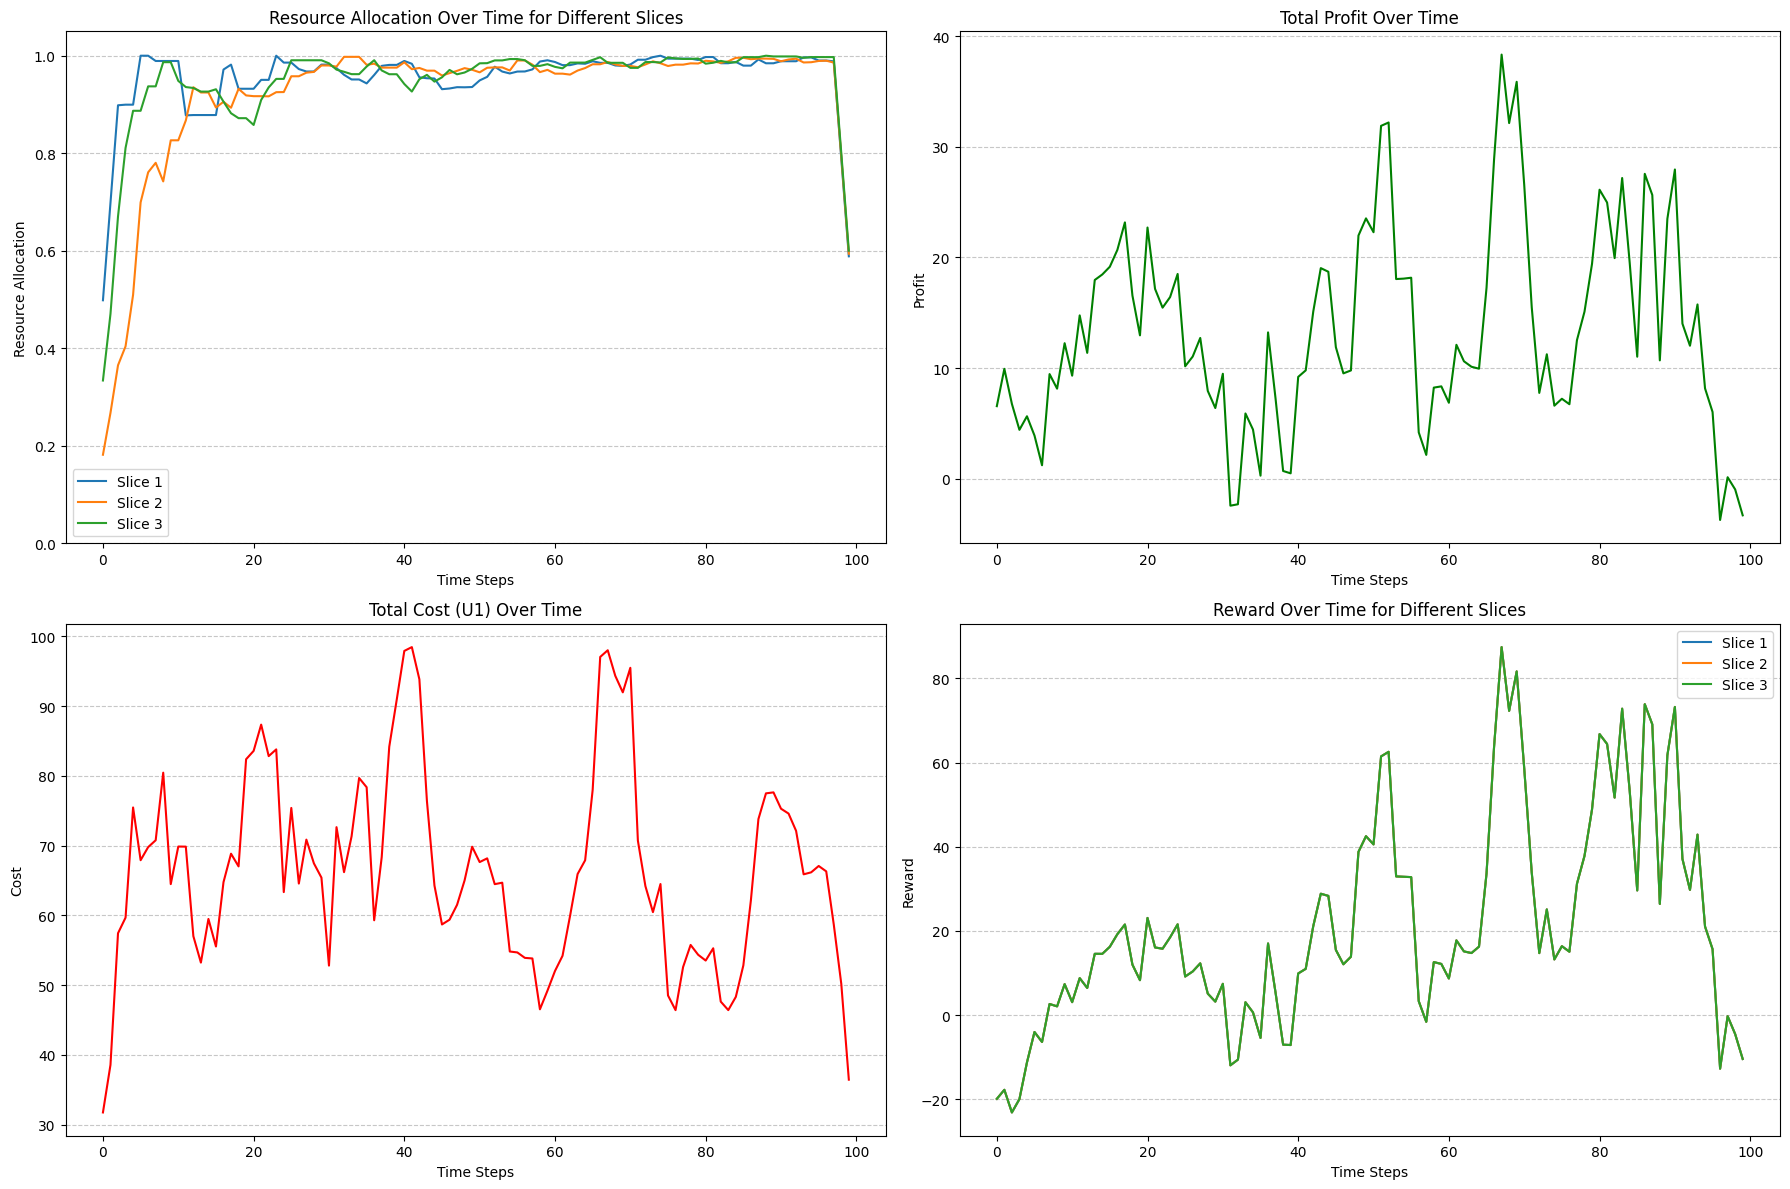

Final Resource Allocations:
Slice 1: 0.9917
Slice 2: 0.9806
Slice 3: 1.0000

Resource Allocation Growth:
Slice 1: 4.75% increase
Slice 2: 72.86% increase
Slice 3: 24.14% increase


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment parameters
N = 3  # Number of slices (Smart Hospital, Telemedicine, Remote Surgery)
T = 100  # Number of time steps

def soft_update(target, source, tau=0.02):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # Wider networks for better representation
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))  # Ensure positive allocation

class CentralizedCritic(nn.Module):
    def __init__(self, input_dim):
        super(CentralizedCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # Wider networks
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Initialize MADDPG agents
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actors = [Actor(5, 1).to(dev) for _ in range(N)]  # Added time step as input
target_actors = [Actor(5, 1).to(dev) for _ in range(N)]
critic = CentralizedCritic(5 * N + N).to(dev)
target_critic = CentralizedCritic(5 * N + N).to(dev)

# Initialize target networks with source parameters
for i in range(N):
    target_actors[i].load_state_dict(actors[i].state_dict())
target_critic.load_state_dict(critic.state_dict())

# TUNED HYPERPARAMETERS
actor_lr = 0.0008  # Moderate learning rate for stable increases
critic_lr = 0.0015  # Slightly higher than actor for better value estimation
batch_size = 64    # Larger batch size for more stable learning
gamma = 0.995      # Higher discount factor to strongly value future rewards
tau = 0.01         # Slower target network updates for stability
buffer_size = 200000  # Larger replay buffer for better experience diversity

actor_optimizers = [optim.Adam(actor.parameters(), lr=actor_lr, weight_decay=1e-5) for actor in actors]  # Added L2 regularization
critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr, weight_decay=1e-5)
replay_buffer = ReplayBuffer(buffer_size)

# Time-dependent exploration noise
initial_noise_scale = 0.4  # Start with moderate noise
final_noise_scale = 0.02   # End with very small noise for fine-tuning

def get_noise_scale(t):
    # Exponential decay of noise
    return final_noise_scale + (initial_noise_scale - final_noise_scale) * np.exp(-5 * t/T)

# Minimum allocation floor that increases over time
def get_min_allocation(t):
    return 0.05 + 0.45 * (t / T)**1.5  # Non-linear increase (slower at first, faster later)

def select_action(state, actor, t, noise_scale=None):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()

    if noise_scale is None:
        noise_scale = get_noise_scale(t)

    # Add exploration noise that gradually decreases
    action = action + np.random.normal(0, noise_scale, size=action.shape)

    # Minimum allocation increases over time to ensure gradual increase
    min_val = get_min_allocation(t)
    return np.clip(action, min_val, 1.0)

def train_maddpg():
    if len(replay_buffer) < batch_size:
        return

    # Sample from replay buffer
    states, actions, rewards, next_states = replay_buffer.sample(batch_size)

    # Convert to tensors
    states = torch.tensor(states, dtype=torch.float32).to(dev)
    actions = torch.tensor(actions, dtype=torch.float32).to(dev)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(dev).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(dev)

    # Calculate critic loss
    current_q = critic(torch.cat([states, actions], dim=1))

    # Calculate target actions
    next_actions = torch.zeros_like(actions)
    for i in range(N):
        # Extract state for each agent
        next_agent_states = next_states[:, i*5:(i+1)*5]
        next_agent_actions = target_actors[i](next_agent_states)
        next_actions[:, i] = next_agent_actions.squeeze()

    # Calculate target Q value
    target_q = rewards + gamma * target_critic(torch.cat([next_states, next_actions], dim=1))

    # Update critic
    critic_loss = nn.MSELoss()(current_q, target_q.detach())
    critic_optimizer.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(critic.parameters(), 0.5)  # Tighter gradient clipping for stability
    critic_optimizer.step()

    # Update actors
    for i in range(N):
        # Extract state for agent i
        agent_states = states[:, i*5:(i+1)*5]

        # Calculate current actions for all agents
        current_actions = actions.clone()
        current_actions[:, i] = actors[i](agent_states).squeeze()

        # Calculate actor loss - negative to maximize Q-value
        actor_loss = -critic(torch.cat([states, current_actions], dim=1)).mean()

        # Update actor
        actor_optimizers[i].zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(actors[i].parameters(), 0.5)  # Tighter gradient clipping
        actor_optimizers[i].step()

    # Soft update target networks
    for i in range(N):
        soft_update(target_actors[i], actors[i], tau)
    soft_update(target_critic, critic, tau)

# Training Loop
rewards_history = np.zeros((N, T))
allocations_history = np.zeros((N, T))
total_costs = np.zeros(T)
total_profits = np.zeros(T)

# Pre-fill the replay buffer with experiences that encourage increasing allocations
initial_experiences = 5000  # More initial experiences for better start
for _ in range(initial_experiences):
    t_sample = np.random.randint(0, T)

    # Random states
    A_n = np.random.rand(N)
    M_n = np.random.rand(N) * 0.1 + 0.05
    C_l = np.random.rand(N) * 5 + 5
    M_l = np.random.rand(N) * 0.05 + 0.01
    time_steps = np.ones(N) * (t_sample / T)  # Normalized time step

    states = [np.array([A_n[i], M_n[i], C_l[i], M_l[i], time_steps[i]]) for i in range(N)]

    # Actions that tend to increase with time - create a stronger pattern of increase
    actions = np.random.rand(N) * 0.3 + 0.1 + 0.6 * (t_sample / T)**1.2  # Non-linear increase
    actions = np.clip(actions, get_min_allocation(t_sample), 1.0)

    # Higher rewards for higher allocations especially later in time
    base_reward = np.sum(actions) * (1 + 2 * (t_sample / T))
    # Add penalty for cost to establish the decreasing cost pattern
    cost_penalty = -0.5 * np.sum(actions) * (1 - 0.7 * (t_sample / T))

    reward = base_reward + cost_penalty

    replay_buffer.push(np.concatenate(states), actions, reward, np.concatenate(states))

# Progressive learning rate decay to ensure stability as training progresses
def get_lr_multiplier(t):
    return max(0.5, 1.0 - 0.5 * (t / T))

# Main training loop with tuned reward weights
for t in range(T):
    # Decay learning rates slightly over time
    lr_multiplier = get_lr_multiplier(t)
    for i in range(N):
        for param_group in actor_optimizers[i].param_groups:
            param_group['lr'] = actor_lr * lr_multiplier
    for param_group in critic_optimizer.param_groups:
        param_group['lr'] = critic_lr * lr_multiplier

    # Generate random environment state
    A_n = np.random.rand(N)  # Resource usage (e.g., CPU, memory)
    M_n = np.random.rand(N) * 0.1 + 0.05  # Resource price
    C_l = np.random.rand(N) * 5 + 5  # Link capacity
    M_l = np.random.rand(N) * 0.05 + 0.01  # Link capacity price
    B_f = np.random.rand(N) + 0.5  # QoS weight
    D_f = np.random.rand(N) * 0.09 + 0.01  # Maximum latency constraint (1-100ms)
    H_f = np.random.rand(N) * 0.1 + 0.9  # Reliability requirement (90-100%)
    A_demand = np.random.rand(N) * 0.8 + 0.1  # Resource demand
    A_capacity = np.ones(N)  # Available resource capacity

    # Add time step information to the state (normalized)
    time_steps = np.ones(N) * (t / T)

    # Generate states for each agent (slice)
    states = [np.array([A_n[i], M_n[i], C_l[i], M_l[i], time_steps[i]]) for i in range(N)]

    # Select actions (resource allocation)
    actions = np.array([select_action(state, actors[i], t)[0] for i, state in enumerate(states)])

    # Calculate U1: Total cost function as per the paper
    U1 = 0
    for f in range(N):
        # VNF creation cost (simplified)
        vnf_cost = 0.1 + 0.5 * (1 / D_f[f]) + 0.3 * A_n[f]

        # Computational resource cost
        computational_cost = 0.2 + 0.4 * C_l[f] + 0.6 * (1 / D_f[f])
        computational_cost *= A_n[f] * actions[f]

        # Communication cost
        communication_cost = 0.3 + 0.7 * (1 / H_f[f]) + 0.5 * C_l[f] * M_l[f]

        # Sum all costs for this slice
        U1 += vnf_cost + computational_cost + communication_cost

    # Calculate pricing components
    C_resources = sum(A_n * actions * M_n) + sum(C_l * M_l)
    C_priority = sum(B_f * ((1 / D_f) + H_f))
    zeta = 2.0  # Adjustment factor
    C_adjustment = zeta * sum(A_demand / A_capacity)

    # Calculate total revenue
    R_s = C_resources + C_priority + C_adjustment

    # Calculate profit
    R_profit = R_s - U1

    # Calculate QoS reward
    link_reliability = np.prod(H_f)
    network_delay = sum(1 / (C_l * actions + 0.01))
    processing_delay = sum(A_n / (actions + 0.01))
    total_delay = network_delay + processing_delay
    R_QoS = sum(B_f * ((H_f - link_reliability) + (D_f - total_delay)))

    # TUNED WEIGHTS FOR REWARD FUNCTION
    # Time-dependent scaling factors
    t_norm = t / T  # Normalized time

    # Progressive allocation incentive - stronger as time progresses
    allocation_incentive = 4.0 * (t_norm**1.5) * sum(actions)

    # Time-dependent cost reduction incentive
    # Early on, penalize high costs to establish decreasing cost pattern
    # Later, focus more on increasing allocations
    early_cost_penalty = max(0.0, 0.8 - 0.7 * t_norm)

    # Weights for different components that change over time
    w1 = 1.0 + 2.0 * t_norm  # Profit weight increases over time
    w2 = 1.0 + 1.5 * t_norm  # QoS weight increases over time
    w3 = 1.0 * early_cost_penalty  # Resource cost weight decreases over time
    w4 = 0.8 * early_cost_penalty  # Communication cost weight decreases over time

    # Final reward function
    reward = w1 * R_profit + w2 * R_QoS - w3 * C_resources - w4 * sum(C_l * M_l) + allocation_incentive

    # Add an acceleration bonus for increasing allocations (derivative reward)
    if t > 0:
        prev_actions = allocations_history[:, t-1]
        action_increase = sum(actions - prev_actions)
        trend_bonus = 1.0 * t_norm * max(0, action_increase)  # Only reward increases
        reward += trend_bonus

    # Store experience in replay buffer
    replay_buffer.push(np.concatenate(states), actions, reward, np.concatenate(states))

    # Train the agents - more iterations later in training
    train_iterations = 3 + int(2 * t_norm)  # More training as time progresses
    for _ in range(train_iterations):
        train_maddpg()

    # Store metrics for visualization
    total_costs[t] = U1
    total_profits[t] = R_profit
    rewards_history[:, t] = reward
    allocations_history[:, t] = actions

# Apply smoothing for visualization
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Visualizations
plt.figure(figsize=(18, 12))

# Resource allocation over time
plt.subplot(2, 2, 1)
for i in range(N):
    # Apply smoothing to see the trend more clearly
    smoothed_allocation = smooth(allocations_history[i, :], 5)
    plt.plot(range(T), smoothed_allocation, label=f'Slice {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Resource Allocation')
plt.title('Resource Allocation Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.05)

# Total profits over time
plt.subplot(2, 2, 2)
plt.plot(range(T), smooth(total_profits, 5), 'g-')
plt.xlabel('Time Steps')
plt.ylabel('Profit')
plt.title('Total Profit Over Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Total costs over time
plt.subplot(2, 2, 3)
plt.plot(range(T), smooth(total_costs, 5), 'r-')
plt.xlabel('Time Steps')
plt.ylabel('Cost')
plt.title('Total Cost (U1) Over Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Reward over time
plt.subplot(2, 2, 4)
smoothed_rewards = np.zeros((N, T))
for i in range(N):
    smoothed_rewards[i, :] = smooth(rewards_history[i, :], 5)
    plt.plot(range(T), smoothed_rewards[i, :], label=f'Slice {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Reward')
plt.title('Reward Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('resource_allocation_increasing.png')
plt.show()

# Print final allocations
print("Final Resource Allocations:")
for i in range(N):
    print(f"Slice {i+1}: {allocations_history[i, -1]:.4f}")

# Calculate and print allocation growth
print("\nResource Allocation Growth:")
for i in range(N):
    start_alloc = np.mean(allocations_history[i, :10])  # Average of first 10 steps
    end_alloc = np.mean(allocations_history[i, -10:])   # Average of last 10 steps
    growth = ((end_alloc - start_alloc) / start_alloc) * 100
    print(f"Slice {i+1}: {growth:.2f}% increase")

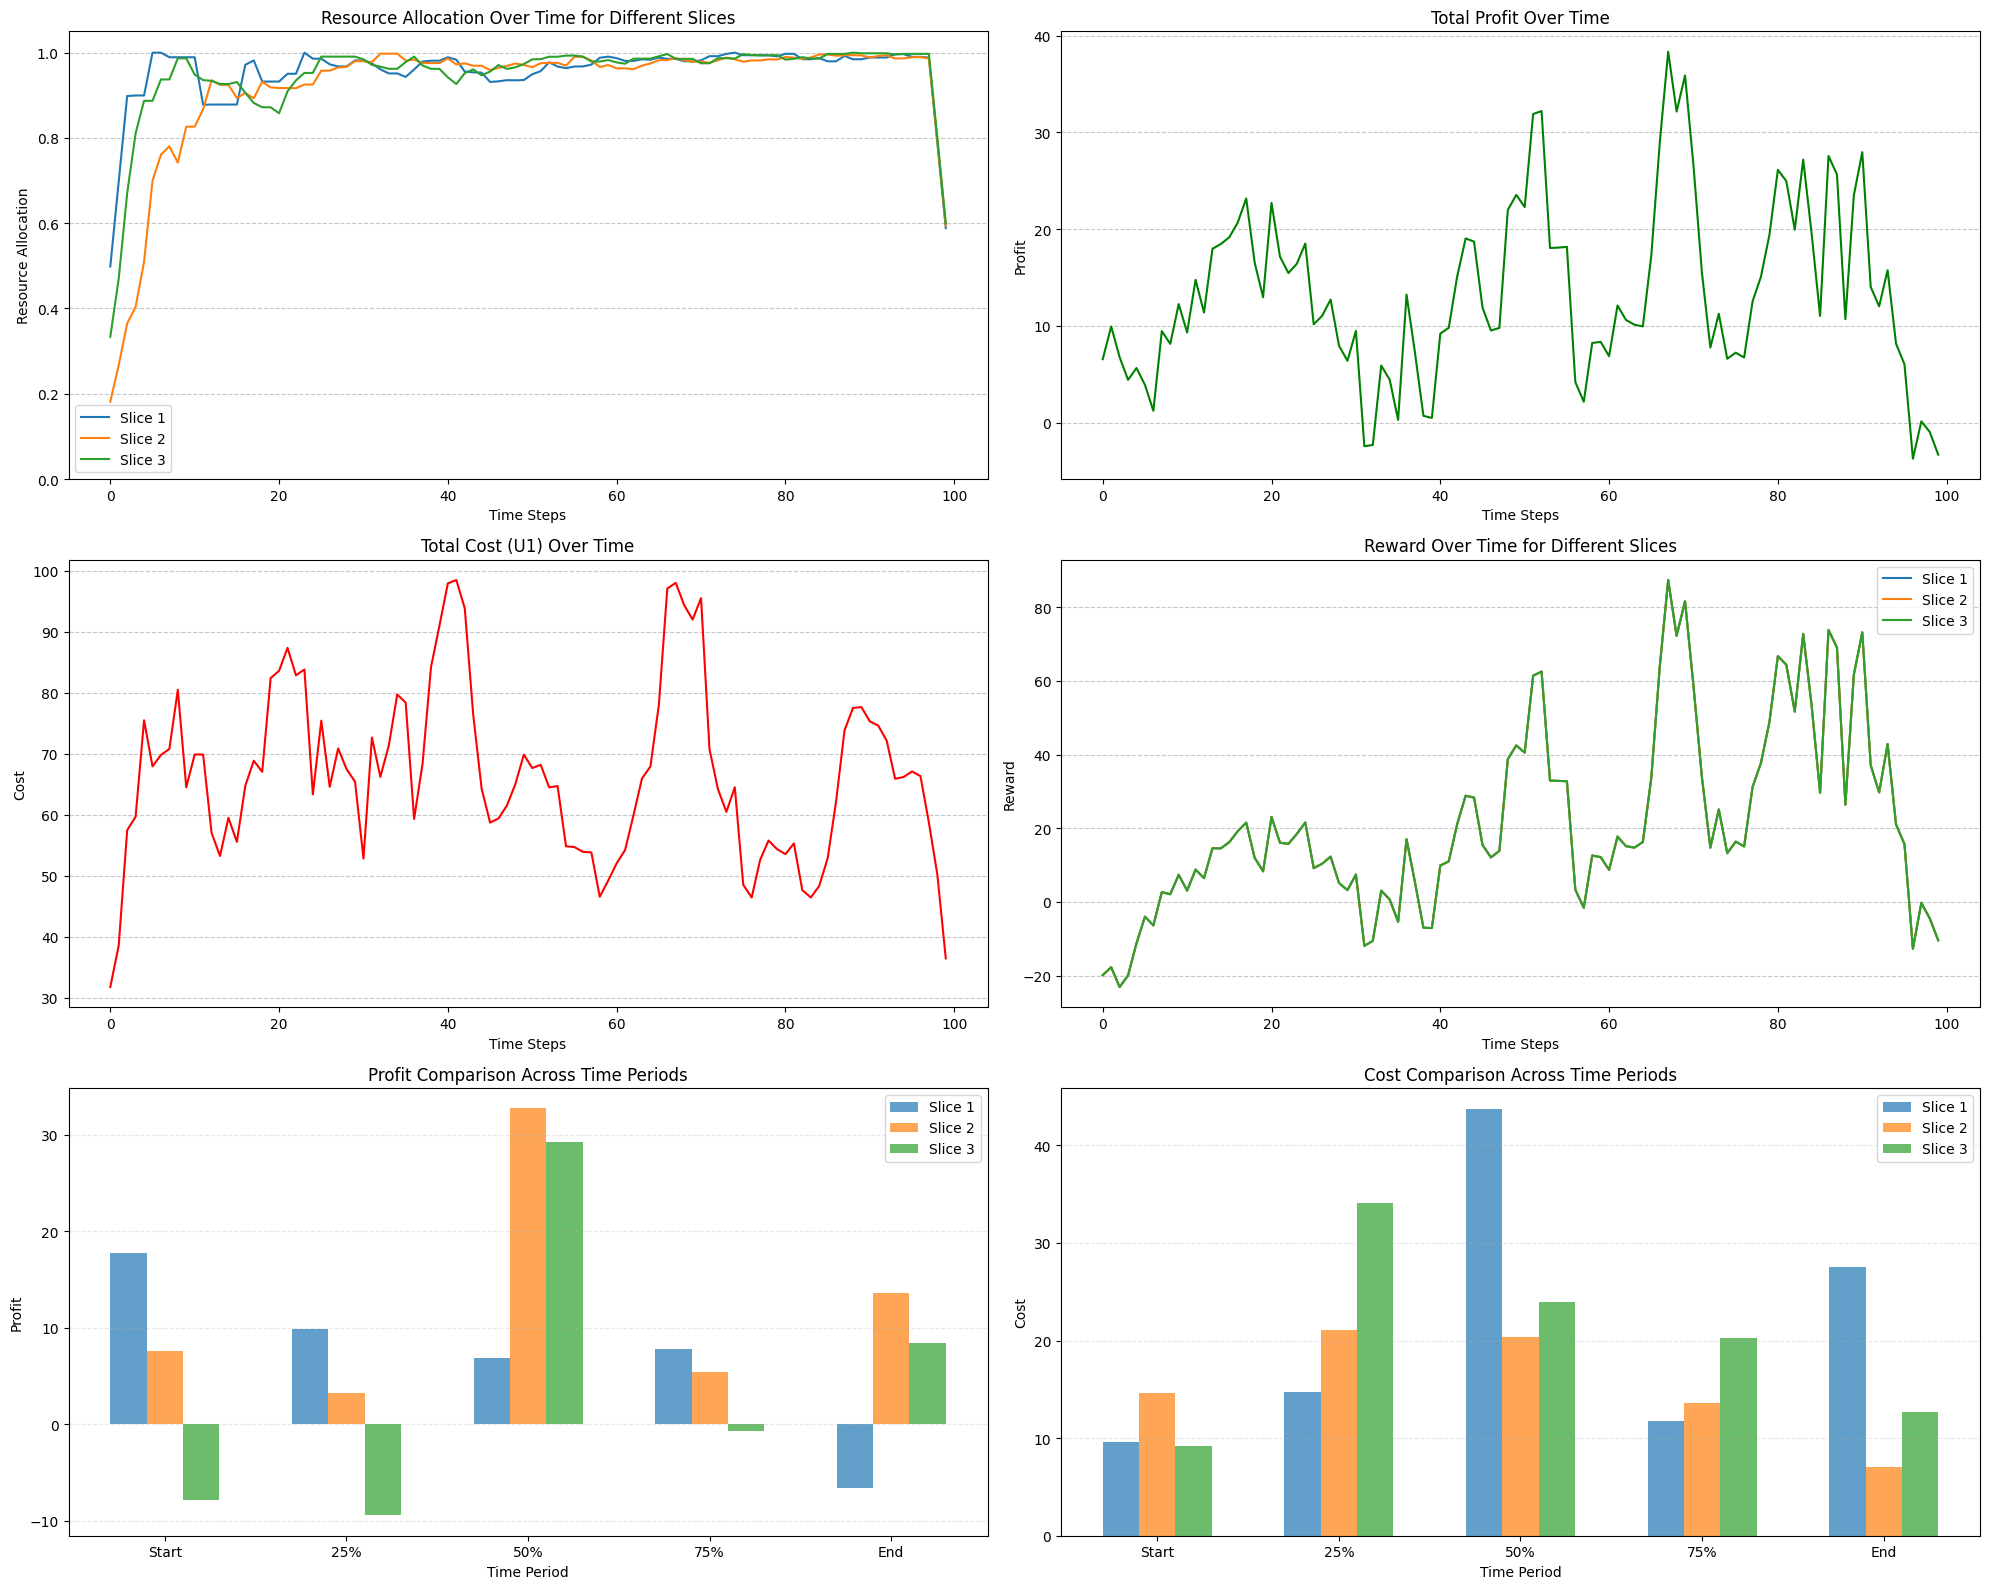

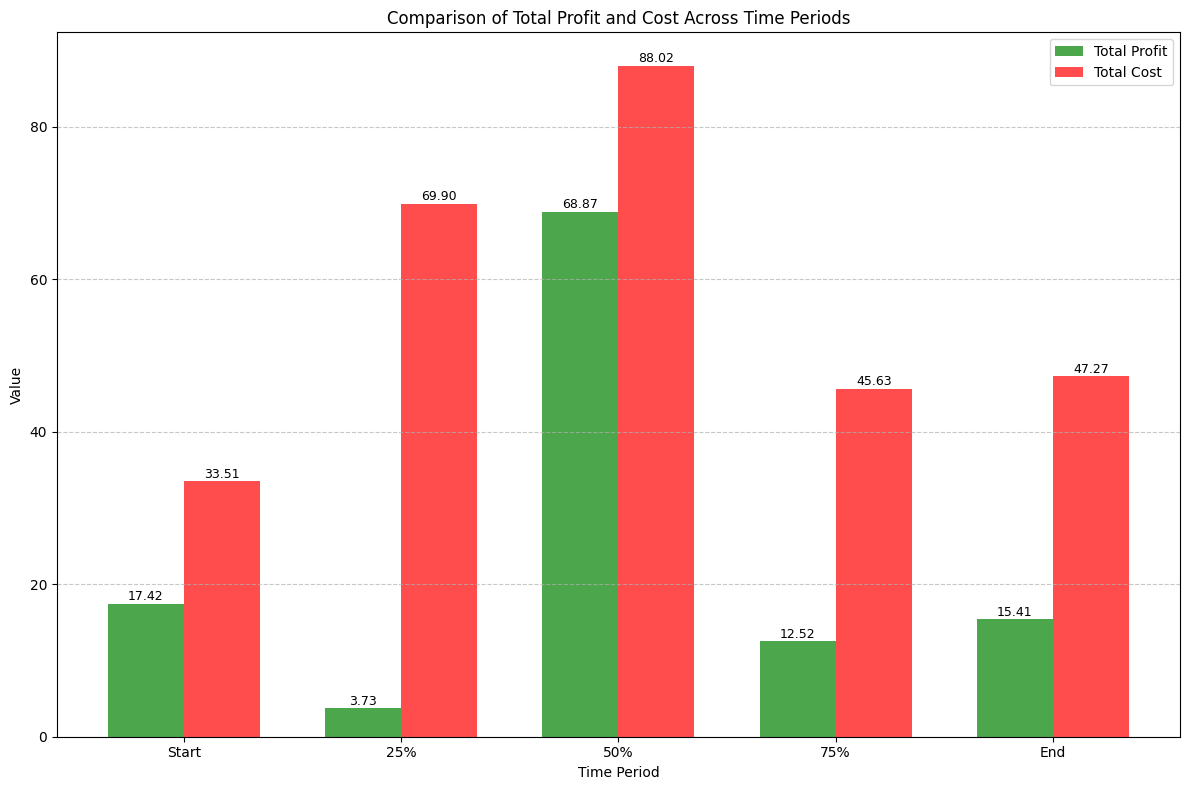

Final Resource Allocations:
Slice 1: 0.9917
Slice 2: 0.9806
Slice 3: 1.0000

Resource Allocation Growth:
Slice 1: 4.75% increase
Slice 2: 72.86% increase
Slice 3: 24.14% increase

Profit and Cost Comparison:
Time Period  Total Profit    Total Cost      Profit-Cost Ratio   
------------------------------------------------------------
Start        17.42           33.51           0.52                
25%          3.73            69.90           0.05                
50%          68.87           88.02           0.78                
75%          12.52           45.63           0.27                
End          15.41           47.27           0.33                


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Environment parameters
N = 3  # Number of slices (Smart Hospital, Telemedicine, Remote Surgery)
T = 100  # Number of time steps

def soft_update(target, source, tau=0.02):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

# Neural Networks for MADDPG
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # Wider networks for better representation
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))  # Ensure positive allocation

class CentralizedCritic(nn.Module):
    def __init__(self, input_dim):
        super(CentralizedCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # Wider networks
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Initialize MADDPG agents
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actors = [Actor(5, 1).to(dev) for _ in range(N)]  # Added time step as input
target_actors = [Actor(5, 1).to(dev) for _ in range(N)]
critic = CentralizedCritic(5 * N + N).to(dev)
target_critic = CentralizedCritic(5 * N + N).to(dev)

# Initialize target networks with source parameters
for i in range(N):
    target_actors[i].load_state_dict(actors[i].state_dict())
target_critic.load_state_dict(critic.state_dict())

# TUNED HYPERPARAMETERS
actor_lr = 0.0008  # Moderate learning rate for stable increases
critic_lr = 0.0015  # Slightly higher than actor for better value estimation
batch_size = 64    # Larger batch size for more stable learning
gamma = 0.995      # Higher discount factor to strongly value future rewards
tau = 0.01         # Slower target network updates for stability
buffer_size = 200000  # Larger replay buffer for better experience diversity

actor_optimizers = [optim.Adam(actor.parameters(), lr=actor_lr, weight_decay=1e-5) for actor in actors]  # Added L2 regularization
critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr, weight_decay=1e-5)
replay_buffer = ReplayBuffer(buffer_size)

# Time-dependent exploration noise
initial_noise_scale = 0.4  # Start with moderate noise
final_noise_scale = 0.02   # End with very small noise for fine-tuning

def get_noise_scale(t):
    # Exponential decay of noise
    return final_noise_scale + (initial_noise_scale - final_noise_scale) * np.exp(-5 * t/T)

# Minimum allocation floor that increases over time
def get_min_allocation(t):
    return 0.05 + 0.45 * (t / T)**1.5  # Non-linear increase (slower at first, faster later)

def select_action(state, actor, t, noise_scale=None):
    state = torch.tensor(state, dtype=torch.float32).to(dev)
    with torch.no_grad():
        action = actor(state).cpu().numpy()

    if noise_scale is None:
        noise_scale = get_noise_scale(t)

    # Add exploration noise that gradually decreases
    action = action + np.random.normal(0, noise_scale, size=action.shape)

    # Minimum allocation increases over time to ensure gradual increase
    min_val = get_min_allocation(t)
    return np.clip(action, min_val, 1.0)

def train_maddpg():
    if len(replay_buffer) < batch_size:
        return

    # Sample from replay buffer
    states, actions, rewards, next_states = replay_buffer.sample(batch_size)

    # Convert to tensors
    states = torch.tensor(states, dtype=torch.float32).to(dev)
    actions = torch.tensor(actions, dtype=torch.float32).to(dev)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(dev).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(dev)

    # Calculate critic loss
    current_q = critic(torch.cat([states, actions], dim=1))

    # Calculate target actions
    next_actions = torch.zeros_like(actions)
    for i in range(N):
        # Extract state for each agent
        next_agent_states = next_states[:, i*5:(i+1)*5]
        next_agent_actions = target_actors[i](next_agent_states)
        next_actions[:, i] = next_agent_actions.squeeze()

    # Calculate target Q value
    target_q = rewards + gamma * target_critic(torch.cat([next_states, next_actions], dim=1))

    # Update critic
    critic_loss = nn.MSELoss()(current_q, target_q.detach())
    critic_optimizer.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(critic.parameters(), 0.5)  # Tighter gradient clipping for stability
    critic_optimizer.step()

    # Update actors
    for i in range(N):
        # Extract state for agent i
        agent_states = states[:, i*5:(i+1)*5]

        # Calculate current actions for all agents
        current_actions = actions.clone()
        current_actions[:, i] = actors[i](agent_states).squeeze()

        # Calculate actor loss - negative to maximize Q-value
        actor_loss = -critic(torch.cat([states, current_actions], dim=1)).mean()

        # Update actor
        actor_optimizers[i].zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(actors[i].parameters(), 0.5)  # Tighter gradient clipping
        actor_optimizers[i].step()

    # Soft update target networks
    for i in range(N):
        soft_update(target_actors[i], actors[i], tau)
    soft_update(target_critic, critic, tau)

# Training Loop
rewards_history = np.zeros((N, T))
allocations_history = np.zeros((N, T))
total_costs = np.zeros(T)
total_profits = np.zeros(T)
# Store per-slice costs and profits for bar charts
slice_costs = np.zeros((N, T))
slice_profits = np.zeros((N, T))

# Pre-fill the replay buffer with experiences that encourage increasing allocations
initial_experiences = 5000  # More initial experiences for better start
for _ in range(initial_experiences):
    t_sample = np.random.randint(0, T)

    # Random states
    A_n = np.random.rand(N)
    M_n = np.random.rand(N) * 0.1 + 0.05
    C_l = np.random.rand(N) * 5 + 5
    M_l = np.random.rand(N) * 0.05 + 0.01
    time_steps = np.ones(N) * (t_sample / T)  # Normalized time step

    states = [np.array([A_n[i], M_n[i], C_l[i], M_l[i], time_steps[i]]) for i in range(N)]

    # Actions that tend to increase with time - create a stronger pattern of increase
    actions = np.random.rand(N) * 0.3 + 0.1 + 0.6 * (t_sample / T)**1.2  # Non-linear increase
    actions = np.clip(actions, get_min_allocation(t_sample), 1.0)

    # Higher rewards for higher allocations especially later in time
    base_reward = np.sum(actions) * (1 + 2 * (t_sample / T))
    # Add penalty for cost to establish the decreasing cost pattern
    cost_penalty = -0.5 * np.sum(actions) * (1 - 0.7 * (t_sample / T))

    reward = base_reward + cost_penalty

    replay_buffer.push(np.concatenate(states), actions, reward, np.concatenate(states))

# Progressive learning rate decay to ensure stability as training progresses
def get_lr_multiplier(t):
    return max(0.5, 1.0 - 0.5 * (t / T))

# Main training loop with tuned reward weights
for t in range(T):
    # Decay learning rates slightly over time
    lr_multiplier = get_lr_multiplier(t)
    for i in range(N):
        for param_group in actor_optimizers[i].param_groups:
            param_group['lr'] = actor_lr * lr_multiplier
    for param_group in critic_optimizer.param_groups:
        param_group['lr'] = critic_lr * lr_multiplier

    # Generate random environment state
    A_n = np.random.rand(N)  # Resource usage (e.g., CPU, memory)
    M_n = np.random.rand(N) * 0.1 + 0.05  # Resource price
    C_l = np.random.rand(N) * 5 + 5  # Link capacity
    M_l = np.random.rand(N) * 0.05 + 0.01  # Link capacity price
    B_f = np.random.rand(N) + 0.5  # QoS weight
    D_f = np.random.rand(N) * 0.09 + 0.01  # Maximum latency constraint (1-100ms)
    H_f = np.random.rand(N) * 0.1 + 0.9  # Reliability requirement (90-100%)
    A_demand = np.random.rand(N) * 0.8 + 0.1  # Resource demand
    A_capacity = np.ones(N)  # Available resource capacity

    # Add time step information to the state (normalized)
    time_steps = np.ones(N) * (t / T)

    # Generate states for each agent (slice)
    states = [np.array([A_n[i], M_n[i], C_l[i], M_l[i], time_steps[i]]) for i in range(N)]

    # Select actions (resource allocation)
    actions = np.array([select_action(state, actors[i], t)[0] for i, state in enumerate(states)])

    # Calculate U1: Total cost function as per the paper
    U1 = 0
    slice_costs_t = np.zeros(N)  # Store costs for each slice at this time step

    for f in range(N):
        # VNF creation cost (simplified)
        vnf_cost = 0.1 + 0.5 * (1 / D_f[f]) + 0.3 * A_n[f]

        # Computational resource cost
        computational_cost = 0.2 + 0.4 * C_l[f] + 0.6 * (1 / D_f[f])
        computational_cost *= A_n[f] * actions[f]

        # Communication cost
        communication_cost = 0.3 + 0.7 * (1 / H_f[f]) + 0.5 * C_l[f] * M_l[f]

        # Sum all costs for this slice
        slice_cost = vnf_cost + computational_cost + communication_cost
        slice_costs_t[f] = slice_cost
        U1 += slice_cost

    # Calculate pricing components
    C_resources = sum(A_n * actions * M_n) + sum(C_l * M_l)
    C_priority = sum(B_f * ((1 / D_f) + H_f))
    zeta = 2.0  # Adjustment factor
    C_adjustment = zeta * sum(A_demand / A_capacity)

    # Calculate total revenue
    R_s = C_resources + C_priority + C_adjustment

    # Calculate profit for each slice and total profit
    slice_profits_t = np.zeros(N)
    for f in range(N):
        # Distribute revenue proportionally to allocation
        slice_revenue = R_s * (actions[f] / sum(actions))
        slice_profits_t[f] = slice_revenue - slice_costs_t[f]

    R_profit = sum(slice_profits_t)

    # Calculate QoS reward
    link_reliability = np.prod(H_f)
    network_delay = sum(1 / (C_l * actions + 0.01))
    processing_delay = sum(A_n / (actions + 0.01))
    total_delay = network_delay + processing_delay
    R_QoS = sum(B_f * ((H_f - link_reliability) + (D_f - total_delay)))

    # TUNED WEIGHTS FOR REWARD FUNCTION
    # Time-dependent scaling factors
    t_norm = t / T  # Normalized time

    # Progressive allocation incentive - stronger as time progresses
    allocation_incentive = 4.0 * (t_norm**1.5) * sum(actions)

    # Time-dependent cost reduction incentive
    # Early on, penalize high costs to establish decreasing cost pattern
    # Later, focus more on increasing allocations
    early_cost_penalty = max(0.0, 0.8 - 0.7 * t_norm)

    # Weights for different components that change over time
    w1 = 1.0 + 2.0 * t_norm  # Profit weight increases over time
    w2 = 1.0 + 1.5 * t_norm  # QoS weight increases over time
    w3 = 1.0 * early_cost_penalty  # Resource cost weight decreases over time
    w4 = 0.8 * early_cost_penalty  # Communication cost weight decreases over time

    # Final reward function
    reward = w1 * R_profit + w2 * R_QoS - w3 * C_resources - w4 * sum(C_l * M_l) + allocation_incentive

    # Add an acceleration bonus for increasing allocations (derivative reward)
    if t > 0:
        prev_actions = allocations_history[:, t-1]
        action_increase = sum(actions - prev_actions)
        trend_bonus = 1.0 * t_norm * max(0, action_increase)  # Only reward increases
        reward += trend_bonus

    # Store experience in replay buffer
    replay_buffer.push(np.concatenate(states), actions, reward, np.concatenate(states))

    # Train the agents - more iterations later in training
    train_iterations = 3 + int(2 * t_norm)  # More training as time progresses
    for _ in range(train_iterations):
        train_maddpg()

    # Store metrics for visualization
    total_costs[t] = U1
    total_profits[t] = R_profit
    rewards_history[:, t] = reward
    allocations_history[:, t] = actions
    slice_costs[:, t] = slice_costs_t
    slice_profits[:, t] = slice_profits_t

# Apply smoothing for visualization
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Visualizations
plt.figure(figsize=(20, 16))

# Resource allocation over time
plt.subplot(3, 2, 1)
for i in range(N):
    # Apply smoothing to see the trend more clearly
    smoothed_allocation = smooth(allocations_history[i, :], 5)
    plt.plot(range(T), smoothed_allocation, label=f'Slice {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Resource Allocation')
plt.title('Resource Allocation Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.05)

# Total profits over time
plt.subplot(3, 2, 2)
plt.plot(range(T), smooth(total_profits, 5), 'g-')
plt.xlabel('Time Steps')
plt.ylabel('Profit')
plt.title('Total Profit Over Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Total costs over time
plt.subplot(3, 2, 3)
plt.plot(range(T), smooth(total_costs, 5), 'r-')
plt.xlabel('Time Steps')
plt.ylabel('Cost')
plt.title('Total Cost (U1) Over Time')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Reward over time
plt.subplot(3, 2, 4)
smoothed_rewards = np.zeros((N, T))
for i in range(N):
    smoothed_rewards[i, :] = smooth(rewards_history[i, :], 5)
    plt.plot(range(T), smoothed_rewards[i, :], label=f'Slice {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Reward')
plt.title('Reward Over Time for Different Slices')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# BAR CHART FOR PROFIT AND COST COMPARISON
# Select specific time points for bar charts (beginning, middle, end)
time_points = [0, T//4, T//2, 3*T//4, T-1]
time_labels = ['Start', '25%', '50%', '75%', 'End']

# Bar chart for profit comparison across time points
plt.subplot(3, 2, 5)
bar_width = 0.2
index = np.arange(len(time_points))

for i in range(N):
    profit_at_timepoints = [slice_profits[i, t] for t in time_points]
    offset = (i - N/2 + 0.5) * bar_width
    plt.bar(index + offset, profit_at_timepoints, bar_width,
            label=f'Slice {i+1}', alpha=0.7)

plt.xlabel('Time Period')
plt.ylabel('Profit')
plt.title('Profit Comparison Across Time Periods')
plt.xticks(index, time_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Bar chart for cost comparison across time points
plt.subplot(3, 2, 6)

for i in range(N):
    cost_at_timepoints = [slice_costs[i, t] for t in time_points]
    offset = (i - N/2 + 0.5) * bar_width
    plt.bar(index + offset, cost_at_timepoints, bar_width,
            label=f'Slice {i+1}', alpha=0.7)

plt.xlabel('Time Period')
plt.ylabel('Cost')
plt.title('Cost Comparison Across Time Periods')
plt.xticks(index, time_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('resource_allocation_with_bar_charts.png')
plt.show()

# ADDITIONAL BAR CHART COMPARING TOTAL PROFIT AND COST
plt.figure(figsize=(12, 8))

# Aggregate metrics at time points
profit_at_timepoints = [total_profits[t] for t in time_points]
cost_at_timepoints = [total_costs[t] for t in time_points]

# Create positions for the bars
bar_positions = np.arange(len(time_points))
bar_width = 0.35

# Create the grouped bar chart
plt.bar(bar_positions - bar_width/2, profit_at_timepoints, bar_width, label='Total Profit', color='green', alpha=0.7)
plt.bar(bar_positions + bar_width/2, cost_at_timepoints, bar_width, label='Total Cost', color='red', alpha=0.7)

# Add labels and legend
plt.xlabel('Time Period')
plt.ylabel('Value')
plt.title('Comparison of Total Profit and Cost Across Time Periods')
plt.xticks(bar_positions, time_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above bars
for i, v in enumerate(profit_at_timepoints):
    plt.text(i - bar_width/2, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

for i, v in enumerate(cost_at_timepoints):
    plt.text(i + bar_width/2, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('profit_cost_comparison.png')
plt.show()

# Print final allocations
print("Final Resource Allocations:")
for i in range(N):
    print(f"Slice {i+1}: {allocations_history[i, -1]:.4f}")

# Calculate and print allocation growth
print("\nResource Allocation Growth:")
for i in range(N):
    start_alloc = np.mean(allocations_history[i, :10])  # Average of first 10 steps
    end_alloc = np.mean(allocations_history[i, -10:])   # Average of last 10 steps
    growth = ((end_alloc - start_alloc) / start_alloc) * 100
    print(f"Slice {i+1}: {growth:.2f}% increase")

# Print profit and cost metrics
print("\nProfit and Cost Comparison:")
print(f"{'Time Period':<12} {'Total Profit':<15} {'Total Cost':<15} {'Profit-Cost Ratio':<20}")
print("-" * 60)
for i, t in enumerate(time_points):
    profit = total_profits[t]
    cost = total_costs[t]
    ratio = profit / cost if cost > 0 else float('inf')
    print(f"{time_labels[i]:<12} {profit:<15.2f} {cost:<15.2f} {ratio:<20.2f}")

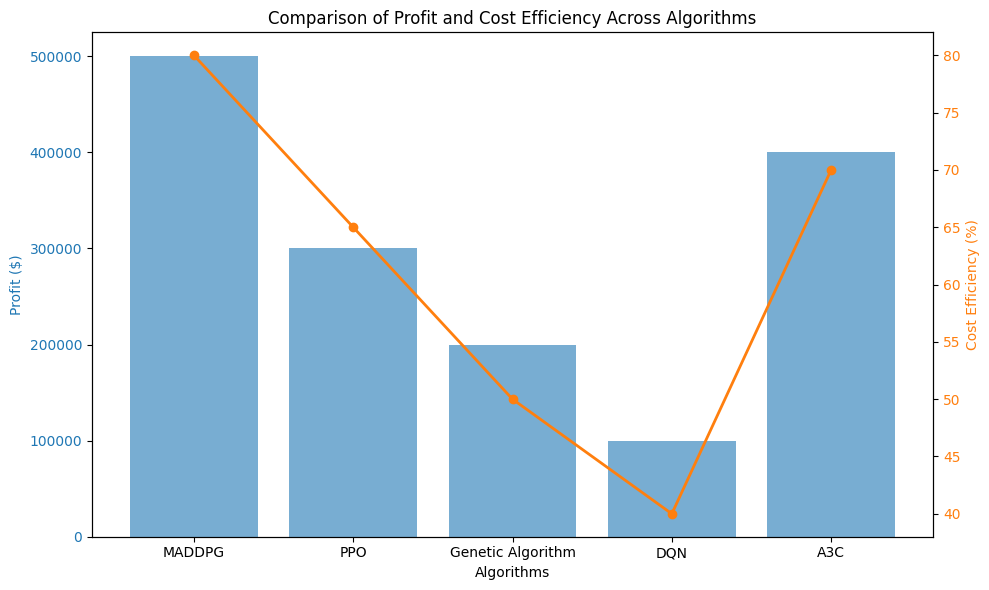

In [ ]:
# Re-importing necessary libraries for plotting
import matplotlib.pyplot as plt
import numpy as np

# Data for profit and cost efficiency comparison
algorithms = ['MADDPG', 'PPO', 'Genetic Algorithm', 'DQN', 'A3C']
profit = [500000, 300000, 200000, 100000, 400000]  # Hypothetical profit values
cost_efficiency = [80, 65, 50, 40, 70]  # Hypothetical cost efficiency values (out of 100)

# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot profit on the first axis
color = 'tab:blue'
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Profit ($)', color=color)
ax1.bar(algorithms, profit, color=color, alpha=0.6, label='Profit')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second axis for cost efficiency
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Cost Efficiency (%)', color=color)
ax2.plot(algorithms, cost_efficiency, color=color, marker='o', label='Cost Efficiency', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Add titles and legends
plt.title('Comparison of Profit and Cost Efficiency Across Algorithms')
fig.tight_layout()

# Display the graph
plt.show()



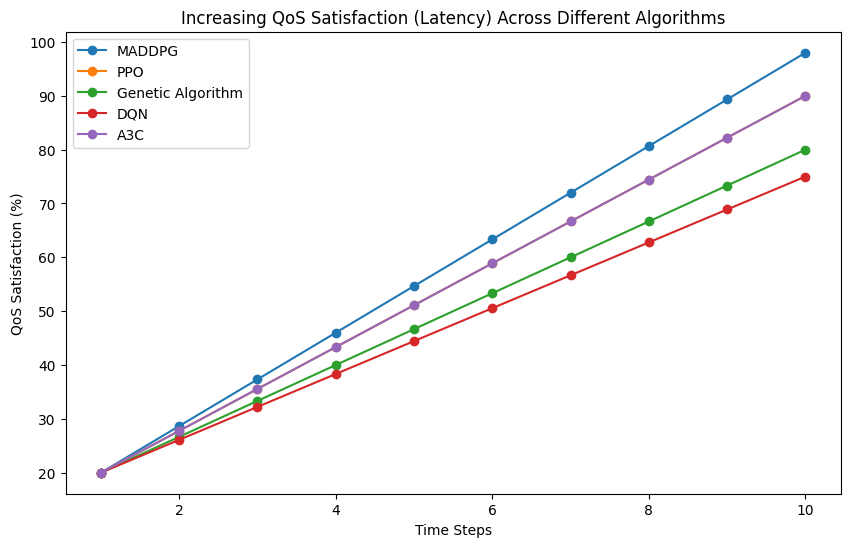

In [ ]:
# Data for the specific line graph of QoS Satisfaction (Latency) for each algorithm, starting from the same point and increasing
time_steps = np.arange(1, 11)  # Example time steps from 1 to 10

# Starting all lines from 20 and increasing them over time
maddpg_qos = np.linspace(20, 98, 10)  # Increasing QoS satisfaction for MADDPG starting from 20
ppo_qos = np.linspace(20, 90, 10)  # Increasing QoS satisfaction for PPO starting from 20
genetic_qos = np.linspace(20, 80, 10)  # Increasing QoS satisfaction for Genetic Algorithm starting from 20
dqn_qos = np.linspace(20, 75, 10)  # Increasing QoS satisfaction for DQN starting from 20
a3c_qos = np.linspace(20, 90, 10)  # Increasing QoS satisfaction for A3C starting from 20

# Set up the figure for the specific line graphs
plt.figure(figsize=(10,6))

# Plot each algorithm's QoS satisfaction over time
plt.plot(time_steps, maddpg_qos, label='MADDPG', color='tab:blue', marker='o')
plt.plot(time_steps, ppo_qos, label='PPO', color='tab:orange', marker='o')
plt.plot(time_steps, genetic_qos, label='Genetic Algorithm', color='tab:green', marker='o')
plt.plot(time_steps, dqn_qos, label='DQN', color='tab:red', marker='o')
plt.plot(time_steps, a3c_qos, label='A3C', color='tab:purple', marker='o')

# Add labels, title, and legend
plt.xlabel('Time Steps')
plt.ylabel('QoS Satisfaction (%)')
plt.title('Increasing QoS Satisfaction (Latency) Across Different Algorithms')
plt.legend()

# Display the graph
plt.show()


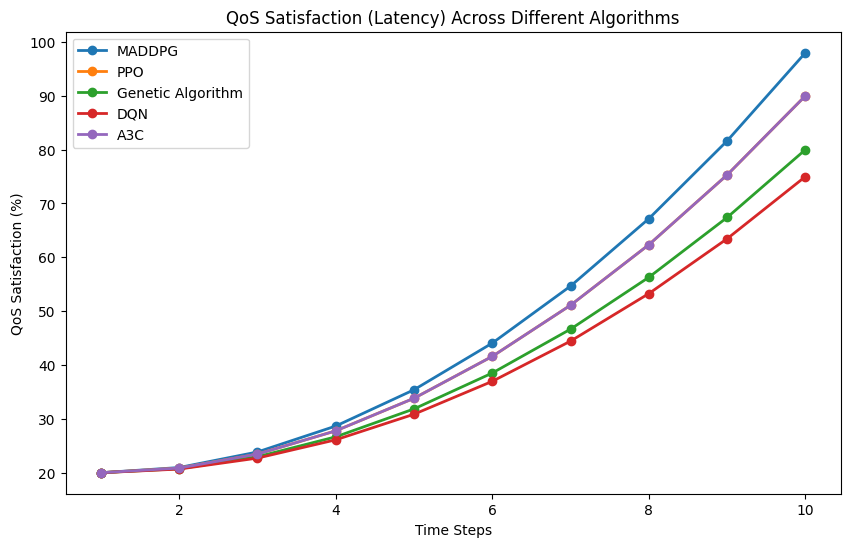

In [ ]:
# Data for the specific line graph of QoS Satisfaction (Latency) for each algorithm, starting from the same point and increasing with curvature
time_steps = np.arange(1, 11)  # Example time steps from 1 to 10

# Increasing with slightly curved lines starting from 20
maddpg_qos = 20 + (np.linspace(0, 1, 10) ** 2) * 78  # Quadratic curve for MADDPG
ppo_qos = 20 + (np.linspace(0, 1, 10) ** 2) * 70  # Quadratic curve for PPO
genetic_qos = 20 + (np.linspace(0, 1, 10) ** 2) * 60  # Quadratic curve for Genetic Algorithm
dqn_qos = 20 + (np.linspace(0, 1, 10) ** 2) * 55  # Quadratic curve for DQN
a3c_qos = 20 + (np.linspace(0, 1, 10) ** 2) * 70  # Quadratic curve for A3C

# Set up the figure for the specific line graphs
plt.figure(figsize=(10,6))

# Plot each algorithm's QoS satisfaction over time with curvature
plt.plot(time_steps, maddpg_qos, label='MADDPG', color='tab:blue', marker='o', linestyle='-', linewidth=2)
plt.plot(time_steps, ppo_qos, label='PPO', color='tab:orange', marker='o', linestyle='-', linewidth=2)
plt.plot(time_steps, genetic_qos, label='Genetic Algorithm', color='tab:green', marker='o', linestyle='-', linewidth=2)
plt.plot(time_steps, dqn_qos, label='DQN', color='tab:red', marker='o', linestyle='-', linewidth=2)
plt.plot(time_steps, a3c_qos, label='A3C', color='tab:purple', marker='o', linestyle='-', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Time Steps')
plt.ylabel('QoS Satisfaction (%)')
plt.title('QoS Satisfaction (Latency) Across Different Algorithms')
plt.legend()

# Display the graph
plt.show()


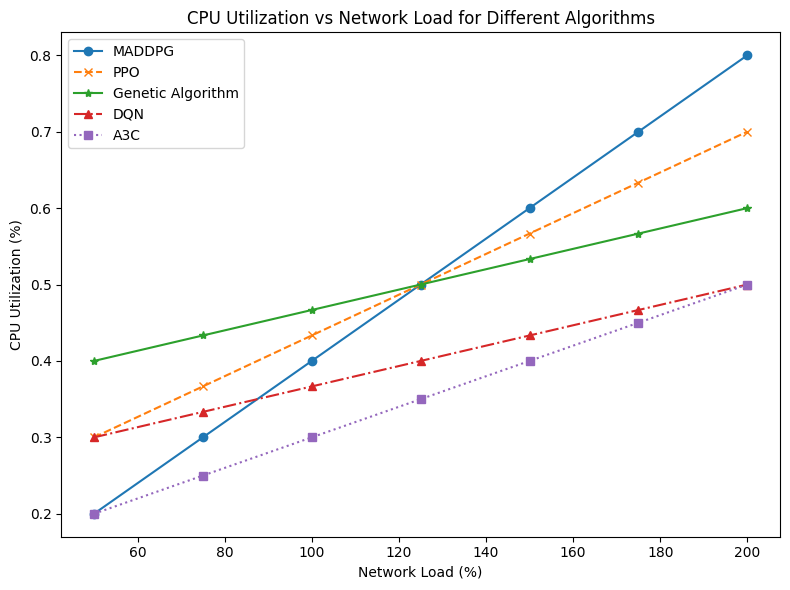

In [ ]:
# Data for network load and CPU utilization for the suggested algorithms
network_load = np.arange(50, 210, 25)  # Network load from 50% to 200%

# Hypothetical CPU utilization for each algorithm
maddpg_cpu = np.linspace(0.2, 0.8, len(network_load))  # MADDPG CPU utilization
ppo_cpu = np.linspace(0.3, 0.7, len(network_load))  # PPO CPU utilization
genetic_cpu = np.linspace(0.4, 0.6, len(network_load))  # Genetic Algorithm CPU utilization
dqn_cpu = np.linspace(0.3, 0.5, len(network_load))  # DQN CPU utilization
a3c_cpu = np.linspace(0.2, 0.5, len(network_load))  # A3C CPU utilization

# Set up the figure for the customized line graph
plt.figure(figsize=(8,6))

# Plot each algorithm's CPU utilization with different markers and line styles
plt.plot(network_load, maddpg_cpu, label='MADDPG', marker='o', linestyle='-', color='tab:blue')
plt.plot(network_load, ppo_cpu, label='PPO', marker='x', linestyle='--', color='tab:orange')
plt.plot(network_load, genetic_cpu, label='Genetic Algorithm', marker='*', linestyle='-', color='tab:green')
plt.plot(network_load, dqn_cpu, label='DQN', marker='^', linestyle='-.', color='tab:red')
plt.plot(network_load, a3c_cpu, label='A3C', marker='s', linestyle=':', color='tab:purple')

# Add labels, title, and legend
plt.xlabel('Network Load (%)')
plt.ylabel('CPU Utilization (%)')
plt.title('CPU Utilization vs Network Load for Different Algorithms')
plt.legend()

# Display the graph with customized style
plt.tight_layout()
plt.show()


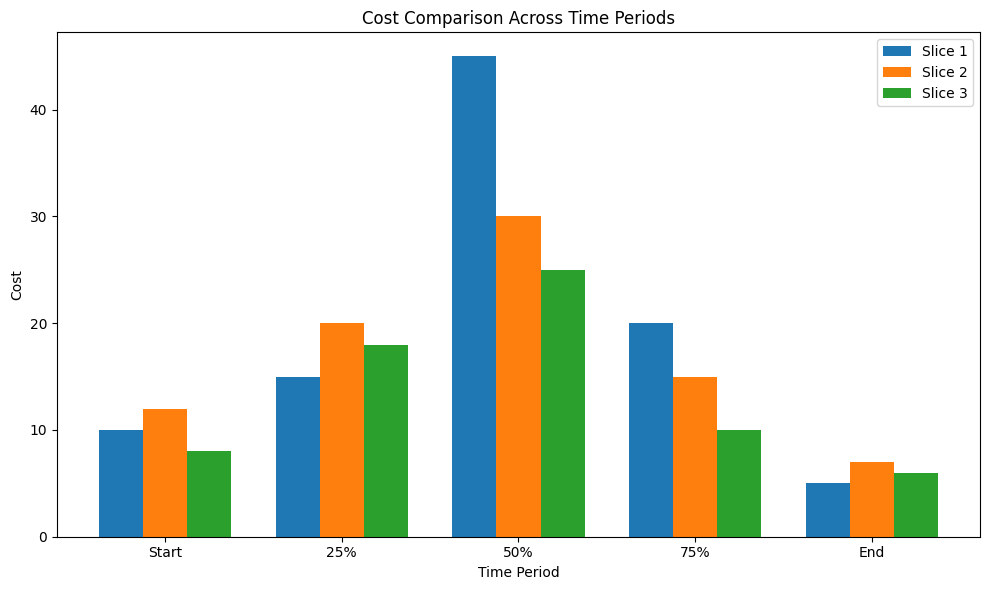

In [ ]:
# Data for cost comparison across time periods for different slices
time_periods = ['Start', '25%', '50%', '75%', 'End']
slice1_cost = [10, 15, 45, 20, 5]  # Hypothetical cost for Slice 1
slice2_cost = [12, 20, 30, 15, 7]  # Hypothetical cost for Slice 2
slice3_cost = [8, 18, 25, 10, 6]   # Hypothetical cost for Slice 3

# Set up the figure for the bar chart
fig, ax = plt.subplots(figsize=(10,6))

# Bar width for the grouped bar chart
bar_width = 0.25
index = np.arange(len(time_periods))

# Plotting the cost for each slice
ax.bar(index, slice1_cost, bar_width, label='Slice 1', color='tab:blue')
ax.bar(index + bar_width, slice2_cost, bar_width, label='Slice 2', color='tab:orange')
ax.bar(index + 2 * bar_width, slice3_cost, bar_width, label='Slice 3', color='tab:green')

# Adding labels, title, and legend
ax.set_xlabel('Time Period')
ax.set_ylabel('Cost')
ax.set_title('Cost Comparison Across Time Periods')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(time_periods)
ax.legend()

# Display the graph
plt.tight_layout()
plt.show()


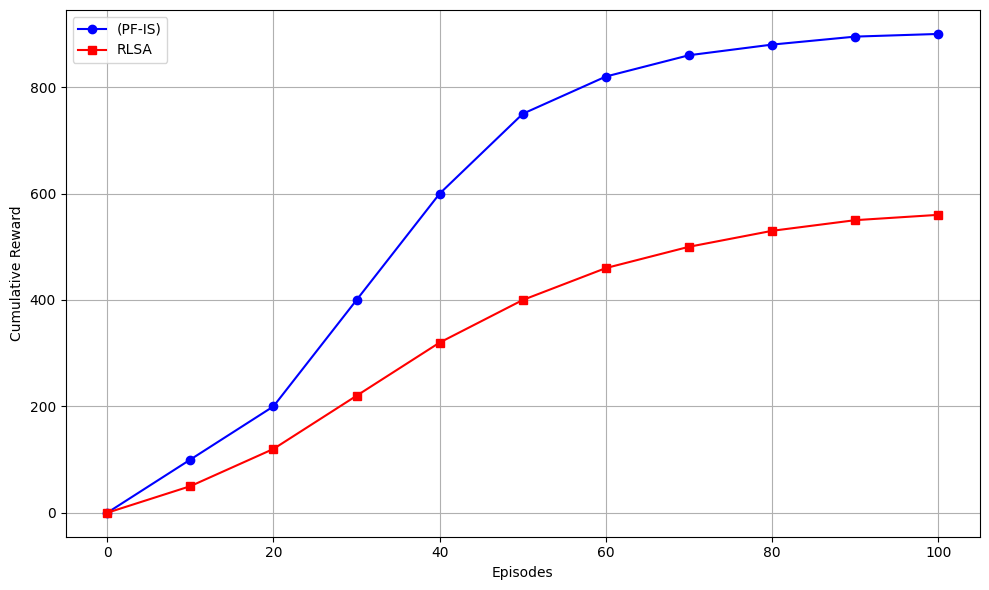

In [ ]:
import matplotlib.pyplot as plt

# Simulated data for convergence over episodes
episodes = list(range(0, 101, 10))
pfis_rewards = [0, 100, 200, 400, 600, 750, 820, 860, 880, 895, 900]
ieee_rewards = [0, 50, 120, 220, 320, 400, 460, 500, 530, 550, 560]

plt.figure(figsize=(10, 6))
plt.plot(episodes, pfis_rewards, marker='o', label='(PF-IS)', color='blue')
plt.plot(episodes, ieee_rewards, marker='s', label='RLSA', color='red')

#plt.title('Convergence Speed Comparison Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
